In [90]:
#python v3.11.3

import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



import os
import datetime

import numpy as np #v1.25.0
import pandas as pd #v2.0.3
import scipy #v1.10.1
import scipy.stats as stats

import seaborn as sns #v0.13.0
import matplotlib as mpl #v3.8.1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

#import matplotlib.spines as spines
from matplotlib.patches import Rectangle

# these files should be in the same directory as this Jupyter notebook
from loader import *
from analysis_functions import *
from plot_functions import *

# to set styles for plotting
mpl.style.use(r"C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\mouse_analysis\full_trial_analysis\mouse_analysis.mplstyle")

#to suppress inaccurate pandas reassignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# 1. Load Files

### Parameters

In [91]:
# directory files are pulled from
csv_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals\\dcz'

# file containing information about animals (cage, age, sex, strain) - must have Animal ID column
metadata_file = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\eunsol_metadata.xlsx'

default_acc_time = 1 # days

### 1.1 Load metadata file

The metadata file allows data from multiple animals with different acclimation 
times to be loaded together. If no metadata is provided, all animals loaded will
be assumed to be acclimated for the `default_acc_time` value. Optional columns
will label each animal with that information and allow splitting data based on
those properties.

If you do not wish to provide metadata, input an empty `.xlsx` file.

Columns used:

- all column names are case sensitive
- column named `Animal ID` (required)
    - this ID must match folder names or lookup will not work
- column named `acc`
    - number of days the animal was acclimated
    - if this value is missing or lookup fails, the `default_acc_time` value 
    will be used
    - this is for alignment of the data, and must be based on the start date of 
    the first file
        - for example, if an animal only has SAT data but was acclimated for 2 
        days, and the first behavior file is dated to the start of SAT, the
        animal should be marked as having been acclimated for 0 days
    - if lookup fails, and the `default_acc_time` does not match the amount of 
    time the animal was acclimated for, its data will not be correctly aligned
- column named `Age` (optional)
    - age of animal
- column named `Sex` (optional)
    - sex of animal
- column named `Cage` (optional)
    - cage animal was trained in
- column named `Strain` (optional)
    - animal strain

Other columns can be present in the metadata file and will be ignored.

In [94]:
metadata = pd.read_excel(metadata_file)

### 1.2 Load data

In [95]:
# this will load all conditions in a directory of multiple conditions
df = []
for d in os.listdir(csv_directory):
    cond = make_condition_df(csv_directory +'\\' + d, d, metadata, 2)
    df.append(cond)
df = pd.concat(df)

PIT15: no metadata
PIT17: no metadata
PIT10: no metadata
PIT11: no metadata


In [96]:
df["depress"] =df["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

# 2. Lick Frequency Analysis

All plotting is done using a combination of the
`seaborn` and `matplotlib` modules.

Parameters

In [97]:
time_bin = 4*60 # minutes

min_trials = 10 # minimum number of trials in a bin to keep
min_water_trials = 1 # minimum number of water trials
min_blank_trials = 1 # minimum number of water trials

## 2.1 Anticipatory licking, 4h bins



### 2.1.1 Analysis

The range `r` is inclusive on both sides.

In [98]:
r = (700, 1000)
ant_data = bin_lickfreq_analysis(df, r, time_bin)
ant_data["depress"] = ant_data["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

In [99]:
ant_mean_statistics, counts, ant_perf = bin_aggregate_analysis(ant_data, min_trials, min_blank_trials, min_water_trials, ["depress","Day", "day_delta", "type"])

total_by_day = sum_trials(counts, ["condition", "animal", "Day"], "trial no")
total_by_day["depress"] = total_by_day["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})
total_by_hour = sum_trials(counts, ["condition", "animal", "Time (hr)"], "trial no")
total_by_hour["depress"] = total_by_hour["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

In [100]:
parts = 5 # number of partitions to divide each day's trials into 
nth_part = 4 # which partition of trials to get (0-indexed)

nth_part_data = get_nth_part_day(ant_data, parts, nth_part)

# TODO: get aggregate analysis to work with last 20% (only aggregates by 4hr bins)
last20_lickfreq, last20_counts, last20_perf = bin_aggregate_analysis(nth_part_data, min_trials, min_blank_trials, min_water_trials, ["depress","day_delta", "type"])

### 2.1.2 Animal N's

Number of animals with data per timebin

In [101]:
num_per_timebin = counts.groupby(["condition", "animal", "Time (hr)"]).first().reset_index().groupby(["condition","Time (hr)"])["animal"].count().reset_index()
num_per_timebin.set_index(["condition", "Time (hr)"]).unstack("Time (hr)")

animal                                                  \
Time (hr)            -48.0 -44.0 -40.0 -36.0 -32.0 -28.0 -24.0 -20.0 -16.0   
condition                                                                    
0.1mg DCZ hm4di        3.0   3.0   5.0   5.0   5.0   4.0   3.0   5.0   5.0   
0.1mg DCZ mcherry      2.0   2.0   3.0   3.0   3.0   1.0   3.0   3.0   3.0   
0.5mg DCZ mcherry      1.0   5.0   5.0   6.0   6.0   6.0   5.0   6.0   6.0   
0.5mg-1mg DCZ hm4di    1.0   4.0   5.0   5.0   5.0   4.0   5.0   5.0   6.0   

                           ...                                            \
Time (hr)           -12.0  ...  8.0   12.0  16.0  20.0  24.0  28.0  32.0   
condition                  ...                                             
0.1mg DCZ hm4di       5.0  ...   5.0   5.0   5.0   4.0   NaN   NaN   NaN   
0.1mg DCZ mcherry     3.0  ...   3.0   3.0   3.0   1.0   NaN   NaN   NaN   
0.5mg DCZ mcherry     6.0  ...   6.0   6.0   5.0   3.0   1.0   4.0   4.0   
0.5mg-1mg DCZ hm4di   6.0  ...   6.0   6.0   7.0   3.0   NaN   3.0   3.0   

                                       
Time (hr)            36.0  40.0  44.0  
condition                              
0.1mg DCZ hm4di       NaN   NaN   NaN  
0.1mg DCZ mcherry     NaN   NaN   NaN  
0.5mg DCZ mcherry     4.0   4.0   2.0  
0.5mg-1mg DCZ hm4di   3.0   3.0   1.0  

[4 rows x 24 columns]

In [102]:
total_water = sum_trials(counts[counts["stimulus"] == "stimulus"], ["condition", "animal", "Day"], "trial no") 
total_water["depress"] = total_water["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})
total_by_hour[total_by_hour["depress"] == 'hm4di'].set_index(["depress", "animal", "Time (hr)"])["trial no"].unstack(level="animal").to_clipboard()

In [116]:
total_by_hour[(total_by_hour["Time (hr)"] == 0) | (total_by_hour["Time (hr)"] == 4)]

,condition,animal,Time (hr),trial no,depress
9,0.1mg DCZ hm4di,OHQ3,0.0,37,hm4di
10,0.1mg DCZ hm4di,OHQ3,4.0,23,hm4di
39,0.1mg DCZ hm4di,OHQ6,0.0,23,hm4di
40,0.1mg DCZ hm4di,OHQ6,4.0,12,hm4di
56,0.1mg DCZ hm4di,OKK4,4.0,73,hm4di
72,0.1mg DCZ hm4di,OKK7,0.0,10,hm4di
98,0.1mg DCZ mcherry,OGY2,0.0,14,mcherry
99,0.1mg DCZ mcherry,OGY2,4.0,28,mcherry
115,0.1mg DCZ mcherry,OKN2,0.0,15,mcherry
116,0.1mg DCZ mcherry,OKN2,4.0,30,mcherry


Total number of animals per condition

In [117]:
counts[counts["Time (hr)"] == 0][["animal", "stimulus","trial no"]].unstack(level="stimulus")

KeyError: 'Requested level (stimulus) does not match index name (None)'

In [103]:
num_per_timebin.groupby("condition")["animal"].max()

condition
0.1mg DCZ hm4di        5
0.1mg DCZ mcherry      3
0.5mg DCZ mcherry      6
0.5mg-1mg DCZ hm4di    7
Name: animal, dtype: int64

### 2.1.3 Plotting

Lick frequency for stimulus and blank trials

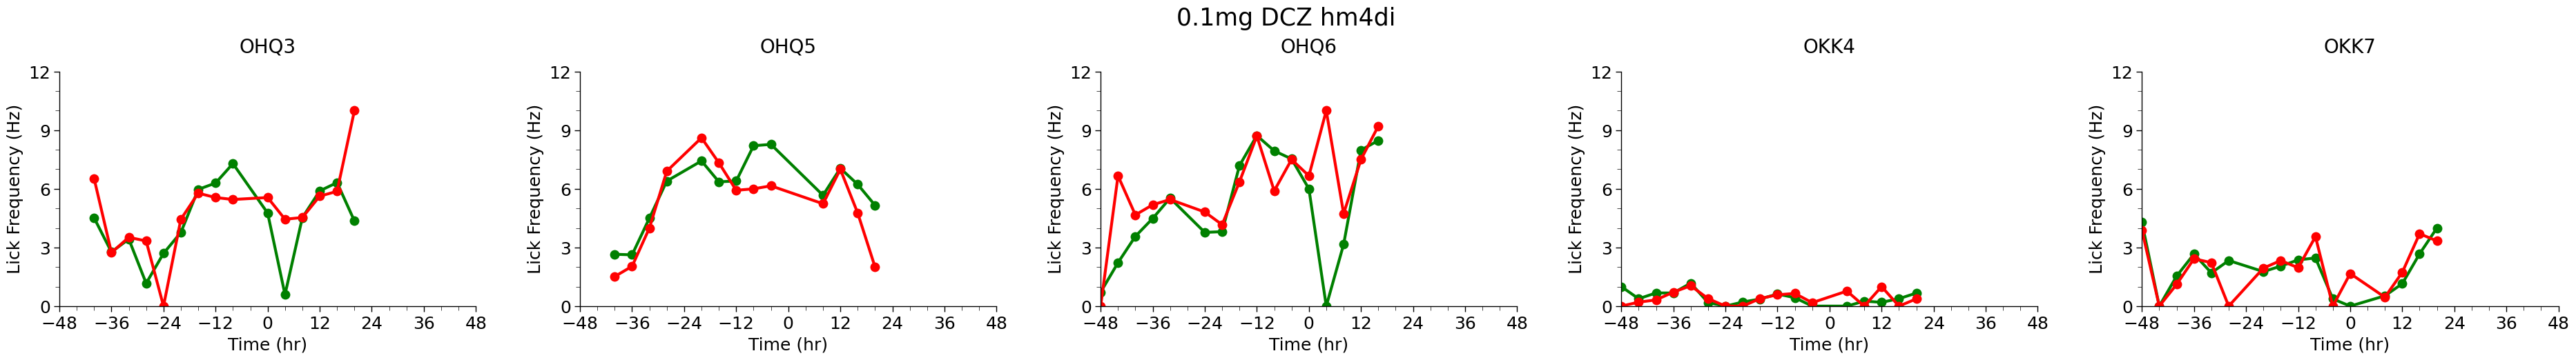

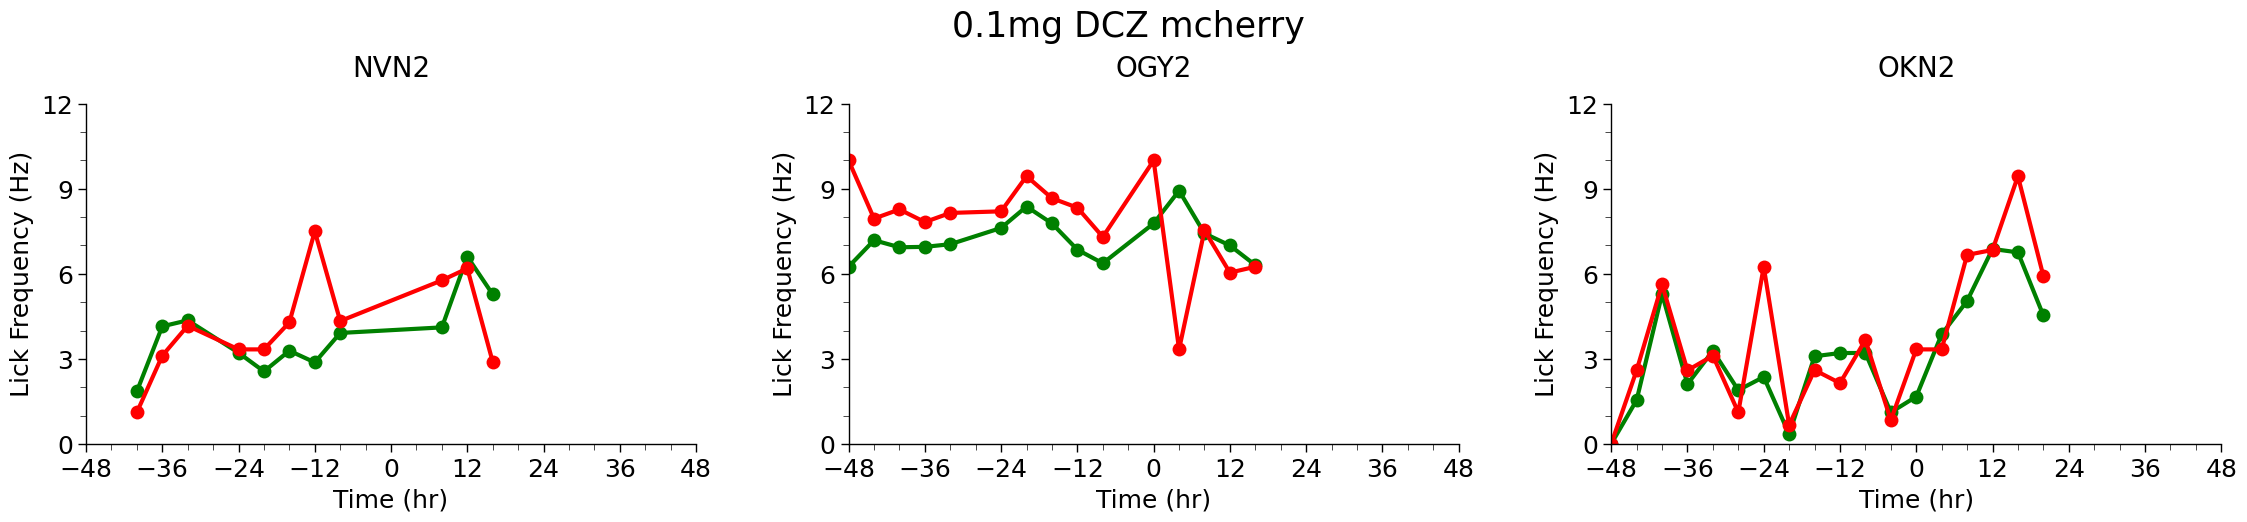

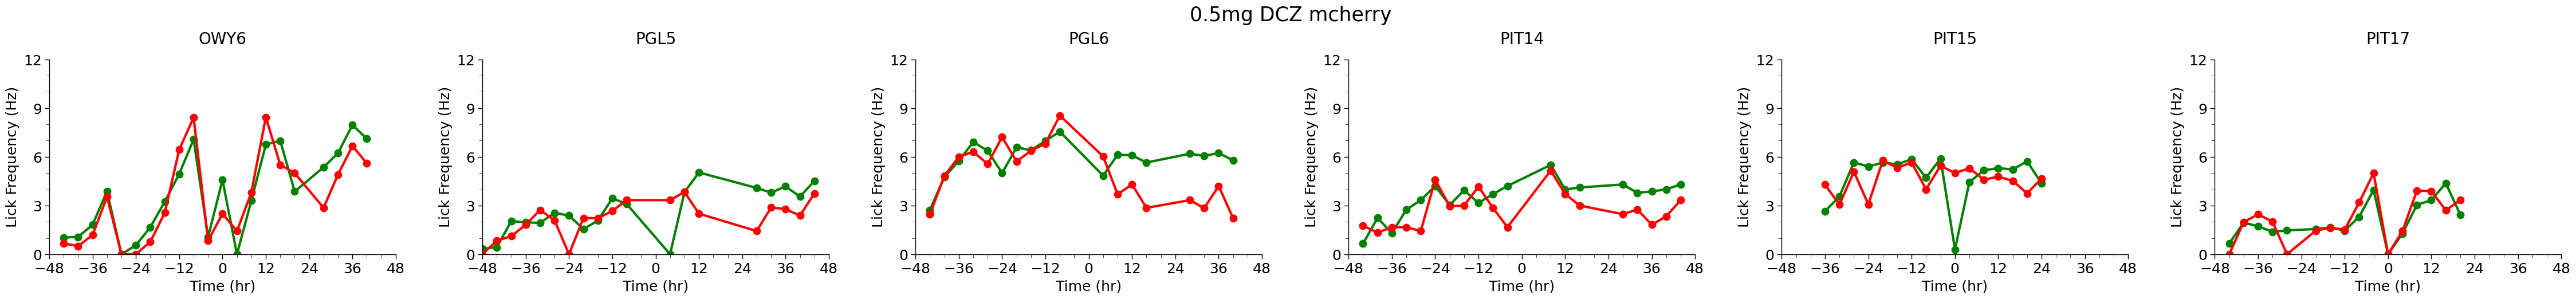

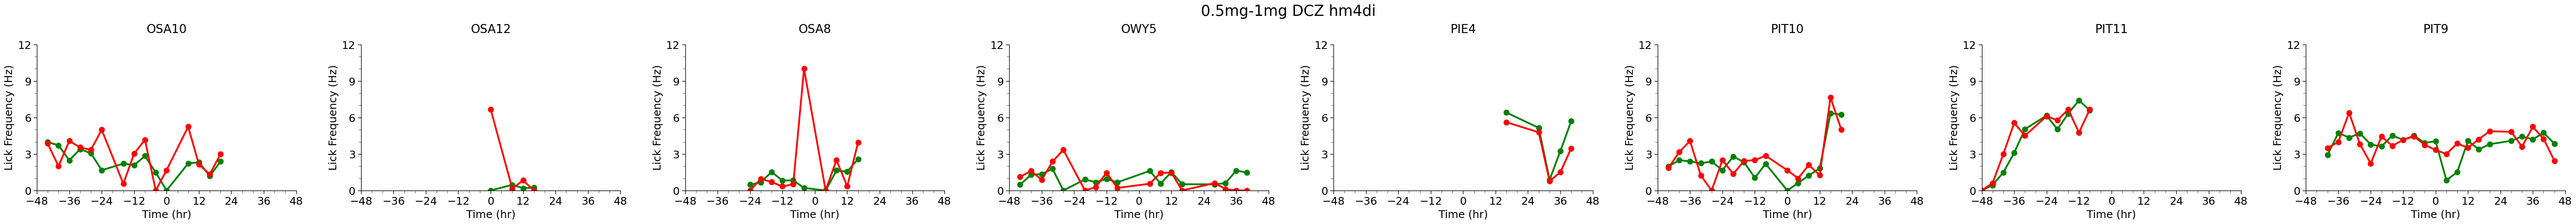

In [108]:
for cond in ant_mean_statistics["condition"].unique():
    g = plot_ant_lickfreq(ant_mean_statistics[ant_mean_statistics["condition"] == cond], legend=False, col="animal", xlim=[-48, 48])
    g.figure.suptitle(cond, y=1.05, x=0.5, fontsize=25)

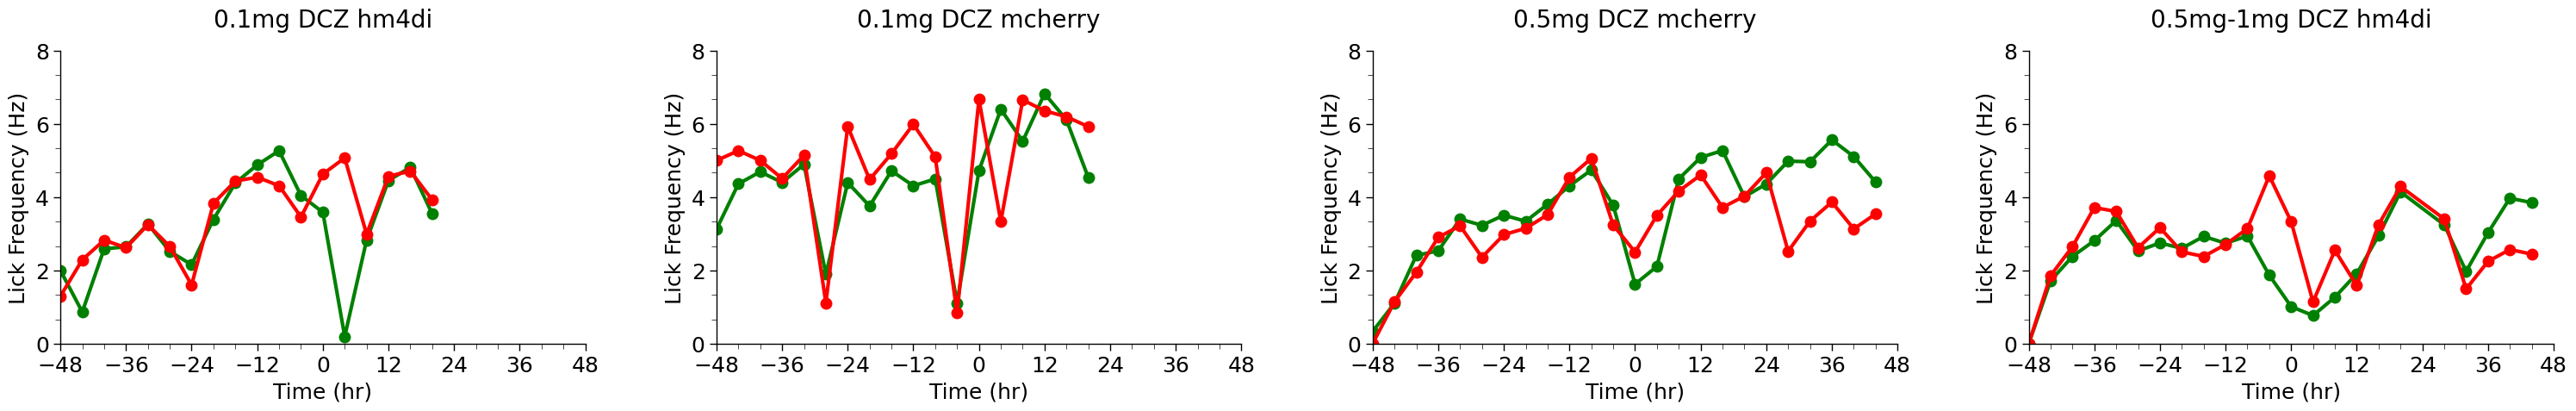

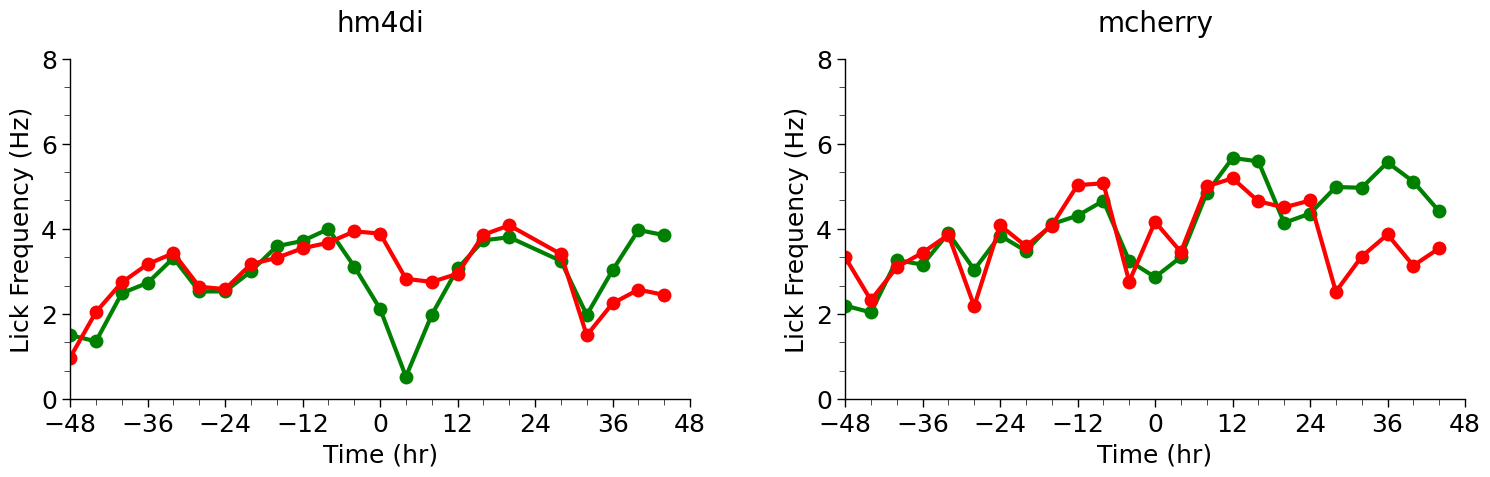

In [104]:
plot_ant_lickfreq(ant_mean_statistics, legend=False, ylim=[0,8], xlim=[-48, 48])
plot_ant_lickfreq(ant_mean_statistics, legend=False, col="depress", ylim=[0,8], xlim=[-48, 48])

Performance (L<sub>stim</sub> - L<sub>blank</sub>) as a line plot and a bar plot

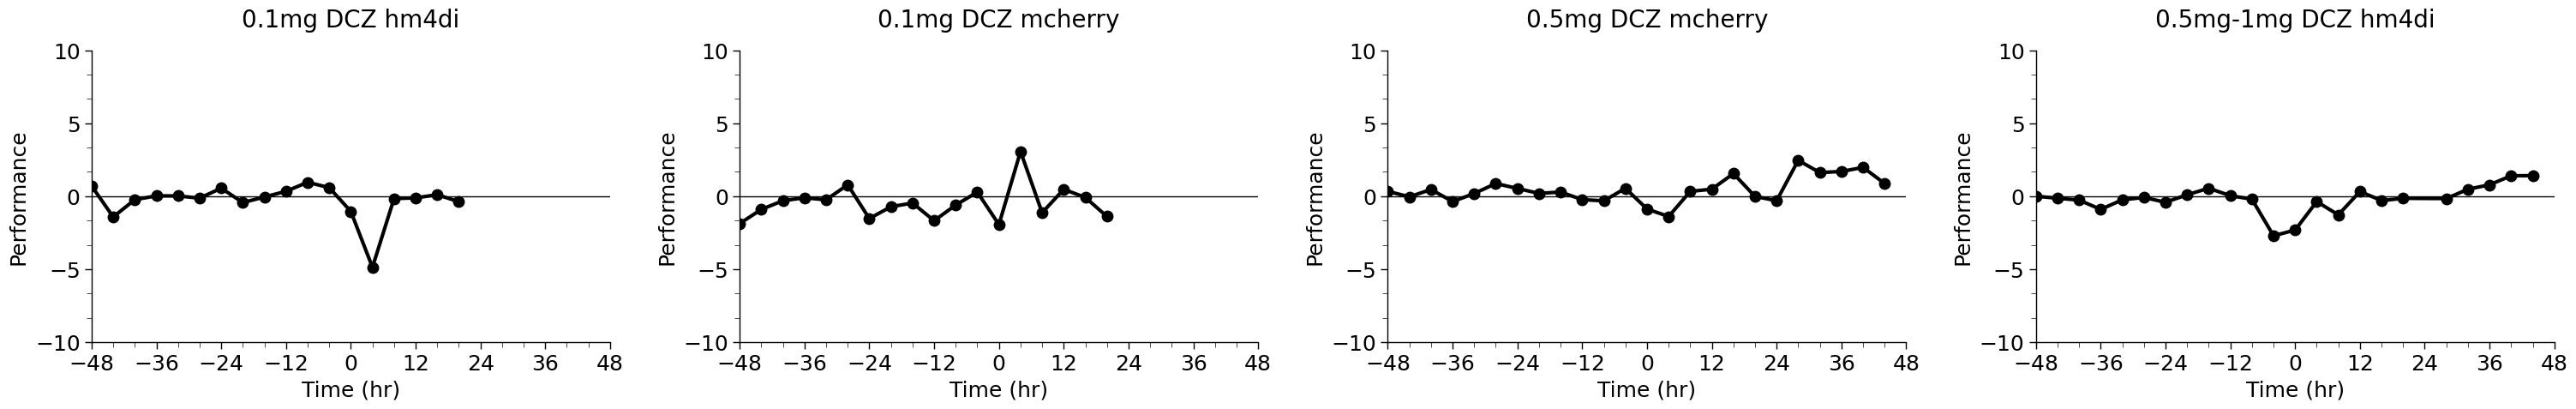

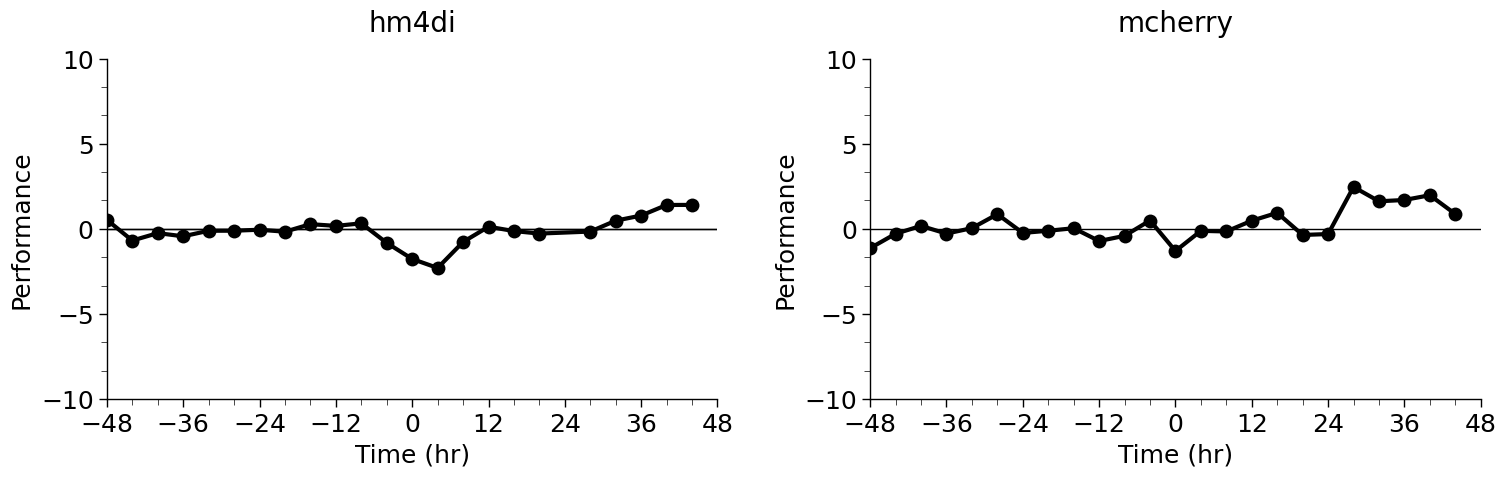

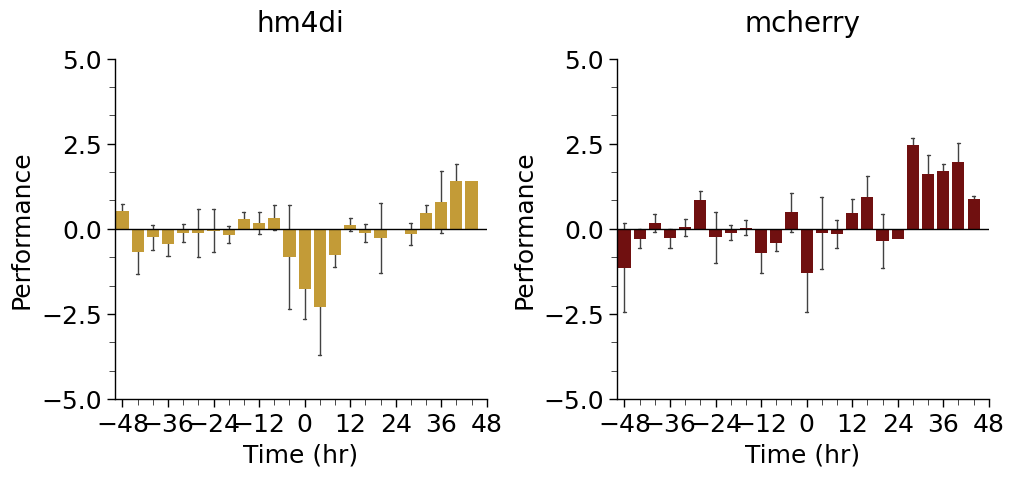

In [109]:
plot_ant_perf(ant_perf, ylabel="Performance", xlim=[-48, 48])
g = plot_ant_perf(ant_perf, ylabel="Performance", xlim=[-48, 48], col="depress", color='k')
g.axes[0][0].axhline(y=0, xmin=0, xmax=1, ls="-", color="black", zorder=0, lw=1)

# using a palette to color different conditions
p = ["goldenrod", "maroon"]
ylim=[-5, 5]
plot_ant_perf_bar(ant_perf, ylim=ylim, hue="depress", col="depress",palette=p,
                  legend=False, col_wrap=2, xlim=[-50, 48], aspect=1.2)

Number of trials by day and by time bin

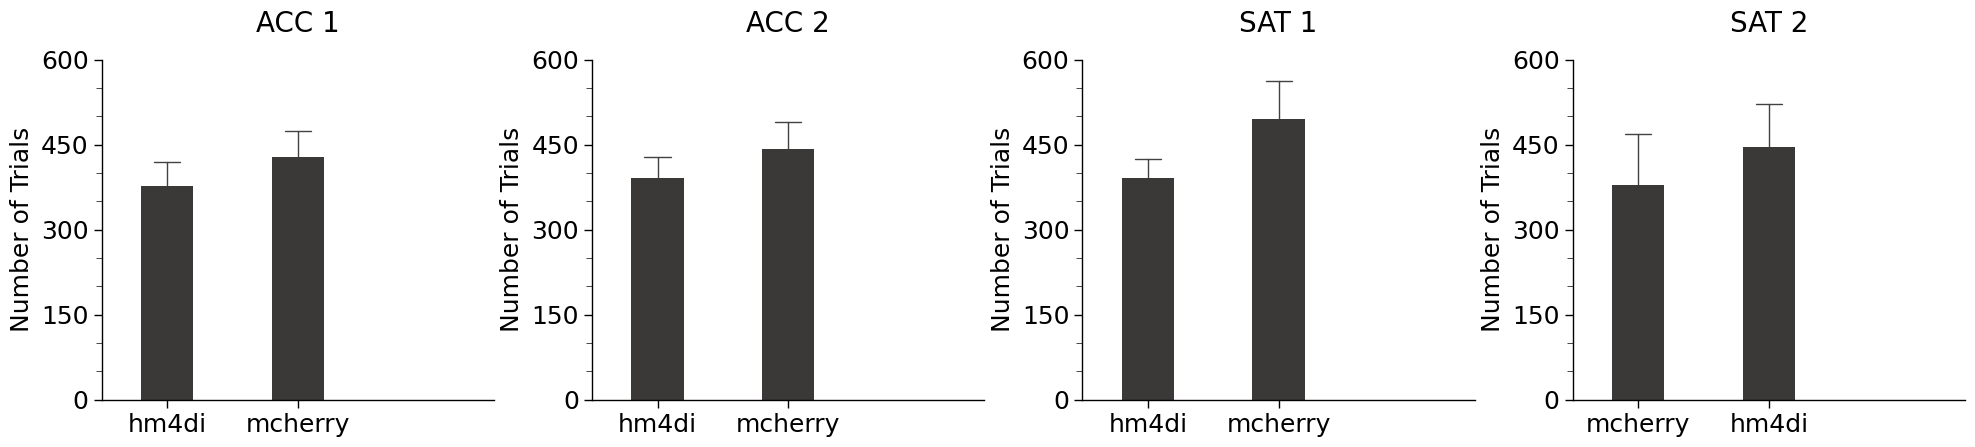

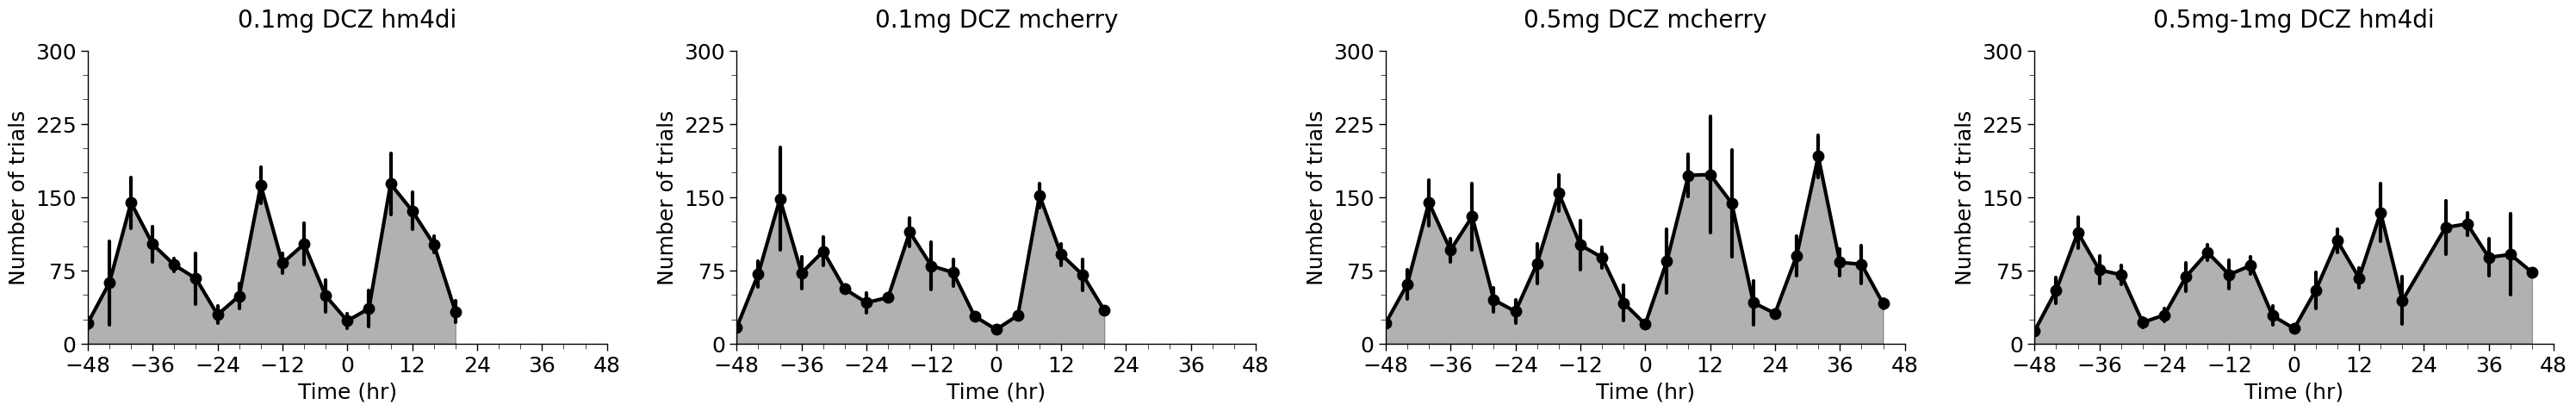

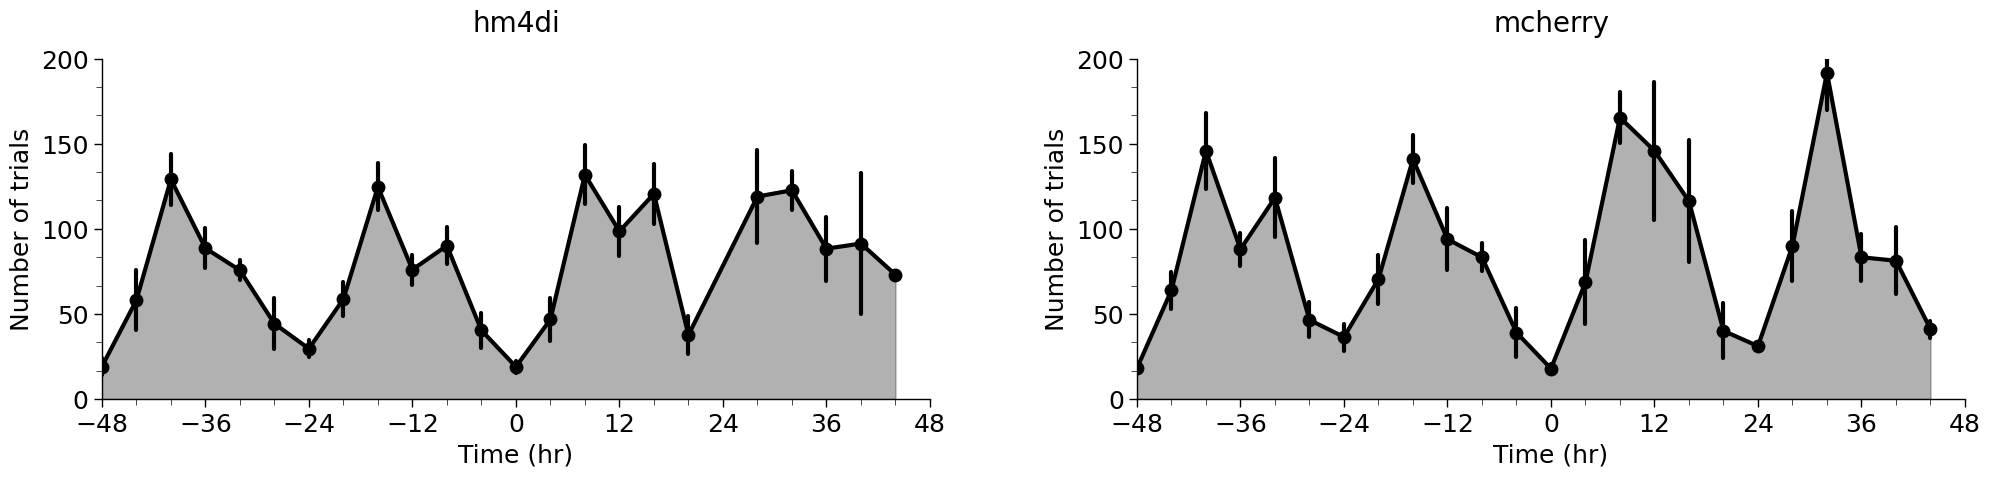

In [111]:
plot_trial_bar(total_by_day, x="depress")
plot_trial_hr(total_by_hour, xlim=[-48, 48])
plot_trial_hr(total_by_hour, xlim=[-48, 48], col="depress", ylim=[0, 200], aspect=2)

Last 20% of trials 

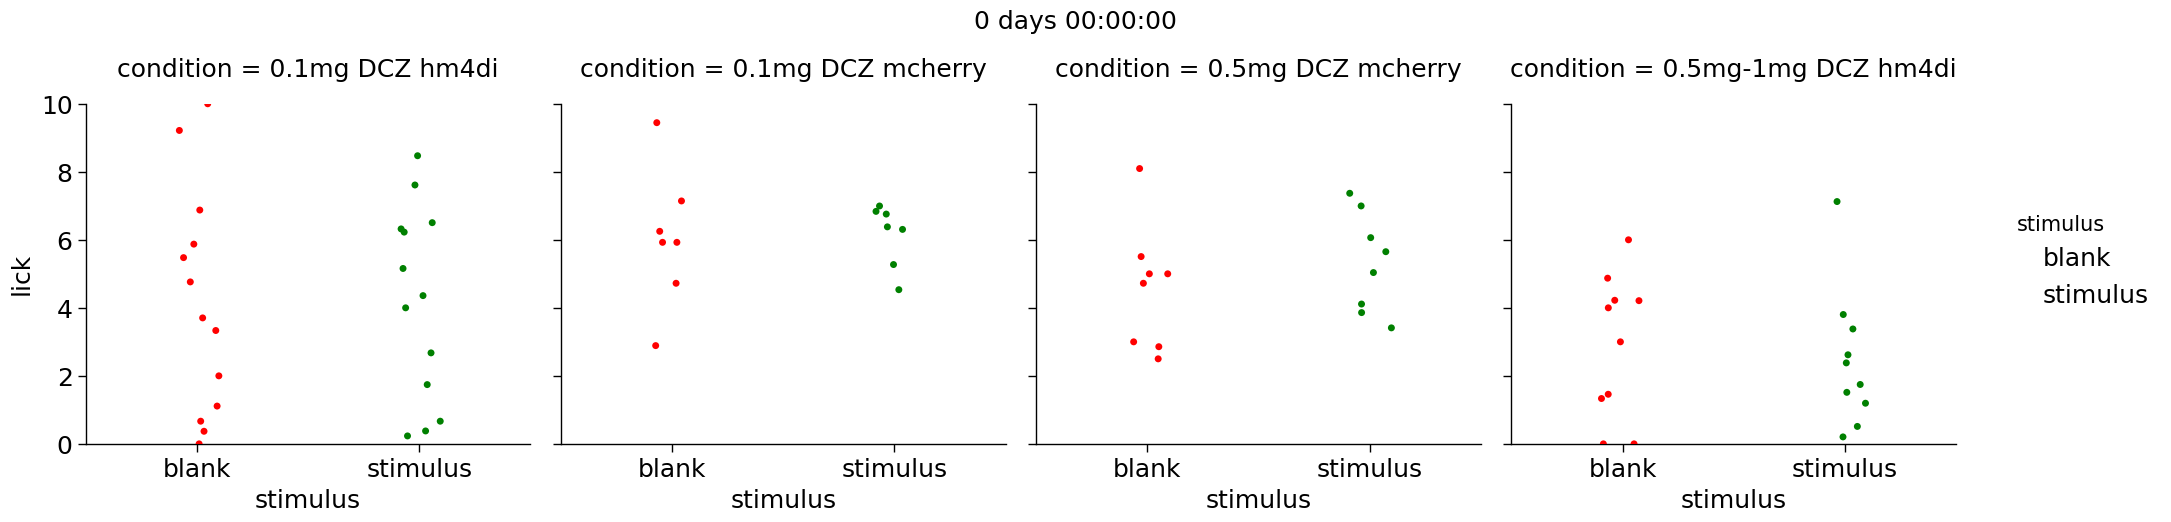

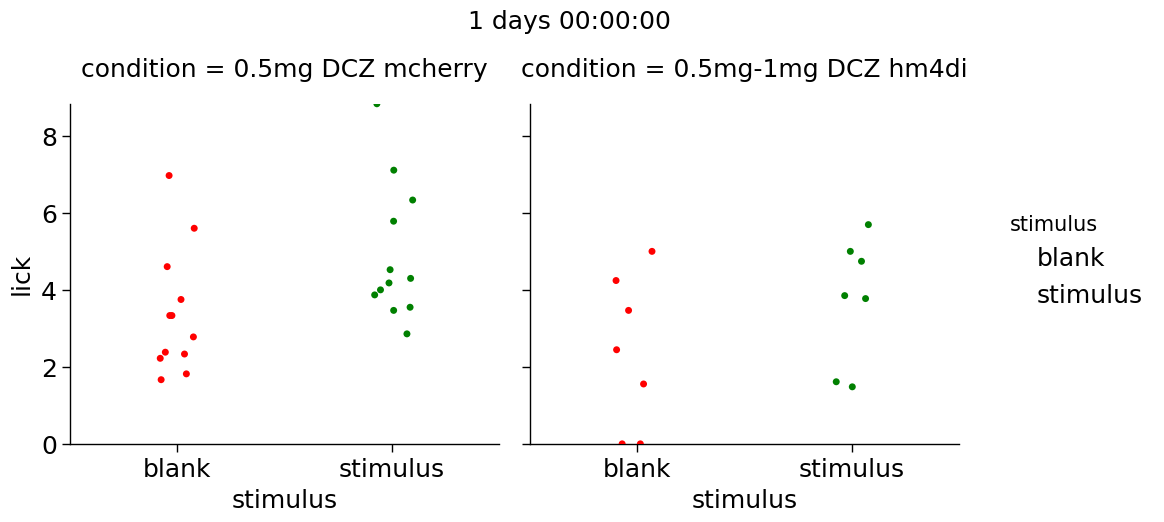

In [72]:
# TODO: incorrect because of incorrect aggregation
for day in last20_lickfreq["day_delta"].unique():
    if day >= pd.to_timedelta(0):
        g = sns.catplot(last20_lickfreq[last20_lickfreq["day_delta"] == day], 
                    y="lick",x="stimulus", kind="strip", hue="stimulus", 
                    palette=["red", "green"], hue_order=["blank", "stimulus"],
                    col="condition")
        g.figure.suptitle(day, y=1.05)

Number of trials by trial type

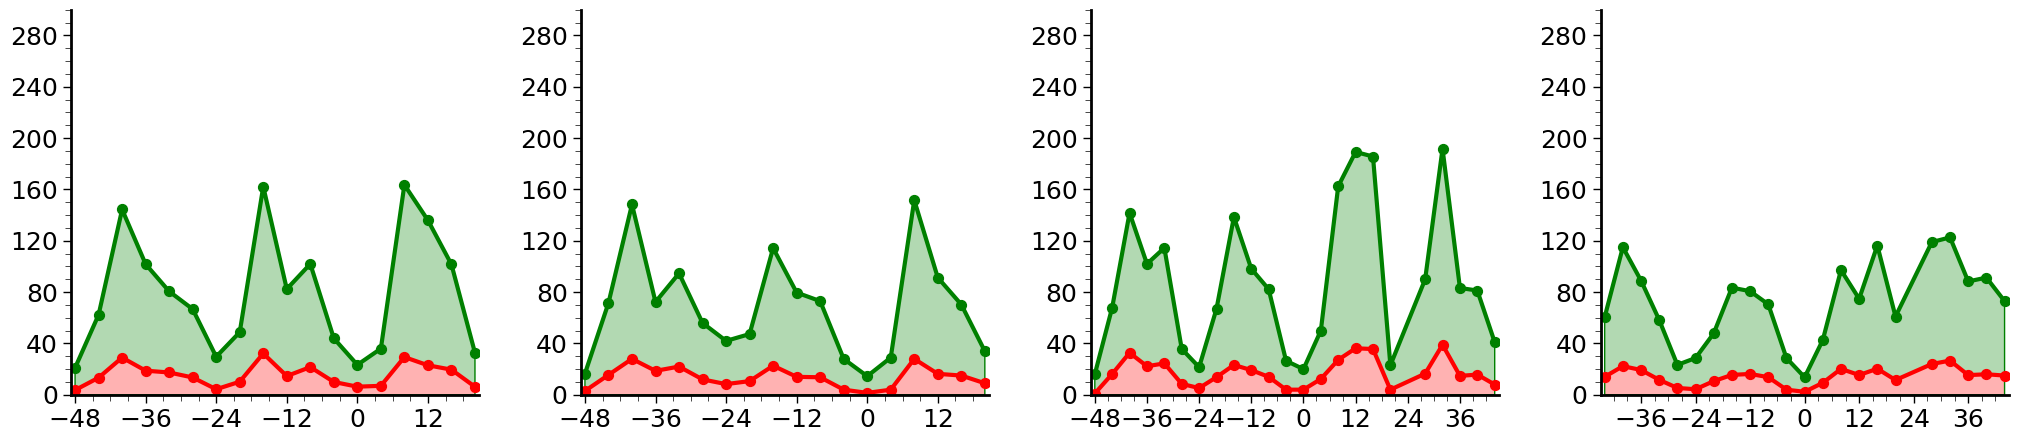

In [73]:
# number of stimulus and blank trials as stacked plot (average but no error bars)
avg_counts = counts.groupby(["condition", "Time (hr)", "stimulus"])["trial no"].mean().reset_index()

conds = avg_counts["condition"].unique()
g, axs = plt.subplots(1, len(conds), figsize=(25,5))


ylims = [0, 300]
ymax = ylims[1]

for i in range(len(conds)):
    lab = avg_counts[avg_counts["condition"] == conds[i]]["stimulus"].unique()
    x = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["Time (hr)"]
    axs[i].spines[["top", "right"]].set_visible(False)
    y1 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["trial no"].reset_index(drop=True)
    y2 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[1])]["trial no"].reset_index(drop=True)
    axs[i].stackplot(x, y1, y2, labels=lab, colors=['#FFB2B2','#B2D9B2'], alpha=1, edgecolor=["green", "red"])
    axs[i].plot(x, y1, color="red")
    axs[i].scatter(x, y1, color="red", s=50)
    axs[i].plot(x, (y1 + y2),color="green")
    axs[i].scatter(x, (y1 + y2), color="green",s=50)    
    ylabel="Number of trials"
    axs[i].set_ylim(ylims)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(12))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(40))
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(3))
    axs[i].yaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].spines[["bottom", "left"]].set(lw=2)
g.subplots_adjust(wspace=0.25)

### 2.1.4 Statistical Tests

Total number of trials between groups (should not be significantly different)

t-test if two conditions, ANOVA otherwise

In [74]:
res = []
for day in total_by_day["Day"].unique(): 
    tt_separated = []
    for c in total_by_day["depress"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["depress"] == c)]["trial no"])
    if len(total_by_day["depress"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["depress"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["Day"].unique())

,statistic,pvalue
ACC 1,-0.573379,0.576546
ACC 2,-0.012042,0.990562
SAT 1,-0.929256,0.379448
SAT 2,-0.262207,0.814182


Total number of trials across days (should not be significantly different)

t-test if only 2 days, ANOVA otherwise

In [75]:
res = []
for c in total_by_day["condition"].unique(): 
    tt_separated = []
    tmp = total_by_day[total_by_day["condition"] == c]
    for day in tmp["Day"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["condition"] == c)]["trial no"])
    if len(total_by_day["Day"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["Day"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
        
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["condition"].unique())

,statistic,pvalue
0.1mg DCZ hm4di,0.071965,0.930962
0.1mg DCZ mcherry,0.076069,0.927631
0.5mg DCZ mcherry,0.358980,0.783703
0.5mg-1mg DCZ hm4di,1.913940,0.181192


Last 20% of trials for all days of SAT

In [76]:
# TODO: incorrect because of incorrect aggregation
res = []

stimcond = last20_lickfreq["stimulus"] == "stimulus"
blankcond = last20_lickfreq["stimulus"] == "blank"

days = last20_lickfreq["day_delta"].unique()
days = days[days >= pd.to_timedelta(0)]

conds = last20_lickfreq["condition"].unique()

ind = last20_lickfreq[last20_lickfreq["day_delta"] >= pd.to_timedelta(0)][["day_delta", "condition"]].apply(tuple, axis=1).unique()

for day, c in ind:
    daycond = last20_lickfreq["day_delta"] == day
    ccond = last20_lickfreq["condition"] == c
    stim = last20_lickfreq[stimcond & daycond & ccond]["lick"]
    blank = last20_lickfreq[blankcond & daycond & ccond]["lick"]
    res.append(stats.ttest_ind(stim, blank, equal_var=False))

pd.DataFrame(res, columns=["statistic", "pvalue"], index=pd.Series(ind).apply(lambda x: x[1] + ", " + str(x[0])))

,statistic,pvalue
"0.1mg DCZ hm4di, 0 days 00:00:00",0.061373,0.951582
"0.1mg DCZ mcherry, 0 days 00:00:00",0.132917,0.897405
"0.5mg DCZ mcherry, 0 days 00:00:00",0.878249,0.395329
"0.5mg DCZ mcherry, 1 days 00:00:00",2.177101,0.040570
"0.5mg-1mg DCZ hm4di, 0 days 00:00:00",-0.502767,0.621235
"0.5mg-1mg DCZ hm4di, 1 days 00:00:00",1.390149,0.190611


## 2.1 Anticipatory licking, 1h bins



### 2.1.1 Analysis

The range `r` is inclusive on both sides.

In [77]:
time_bin = 4*60
min_trials = 1

In [78]:
r = (700, 1000)
ant_data = bin_lickfreq_analysis(df, r, time_bin)
ant_data["depress"] = ant_data["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

In [79]:
ant_mean_statistics, counts, ant_perf = bin_aggregate_analysis(ant_data, min_trials, min_blank_trials, min_water_trials, ["depress","Day", "day_delta", "type"])

total_by_day = sum_trials(counts, ["condition", "animal", "Day"], "trial no")
total_by_day["depress"] = total_by_day["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})
total_by_hour = sum_trials(counts, ["condition", "animal", "Time (hr)"], "trial no")
total_by_hour["depress"] = total_by_hour["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

In [80]:
parts = 5 # number of partitions to divide each day's trials into 
nth_part = 4 # which partition of trials to get (0-indexed)

nth_part_data = get_nth_part_day(ant_data, parts, nth_part)

# TODO: get aggregate analysis to work with last 20% (only aggregates by 4hr bins)
last20_lickfreq, last20_counts, last20_perf = bin_aggregate_analysis(nth_part_data, min_trials, min_blank_trials, min_water_trials, ["depress","day_delta", "type"])

### 2.1.2 Animal N's

Number of animals with data per timebin

In [81]:
cts = counts[(counts["Time (hr)"] < 6) & (counts["Time (hr)"] >= -8)]
num_per_timebin = cts.groupby(["depress", "animal", "Time (hr)"]).first().reset_index().groupby(["depress","Time (hr)"])["animal"].count().reset_index()
num_per_timebin.set_index(["depress", "Time (hr)"]).unstack("Time (hr)")


animal               
Time (hr)   -8.0 -4.0  0.0  4.0
depress                        
hm4di          9    8   11   11
mcherry        7    7    7    7

Total number of animals per condition

In [82]:
print(*counts[counts["depress"] == "hm4di"]["animal"].unique())
print(*counts[counts["depress"] == "mcherry"]["animal"].unique())

OHQ3 OHQ5 OHQ6 OKK4 OKK7 OSA10 OSA12 OSA8 OWY5 PIE4 PIT9
NVN2 OGY2 OKN2 OWY6 PGL5 PGL6 PIT14


In [83]:
cts = counts[(counts["Time (hr)"] < 6) & (counts["Time (hr)"] >= -4)]

cts.groupby(["depress", "Time (hr)"]).first()["animal"].unstack(level="Time (hr)")

Time (hr),-4.0,0.0,4.0
depress,,,
hm4di,OHQ3,OHQ3,OHQ3
mcherry,NVN2,NVN2,NVN2


### 2.1.3 Plotting

Lick frequency for stimulus and blank trials

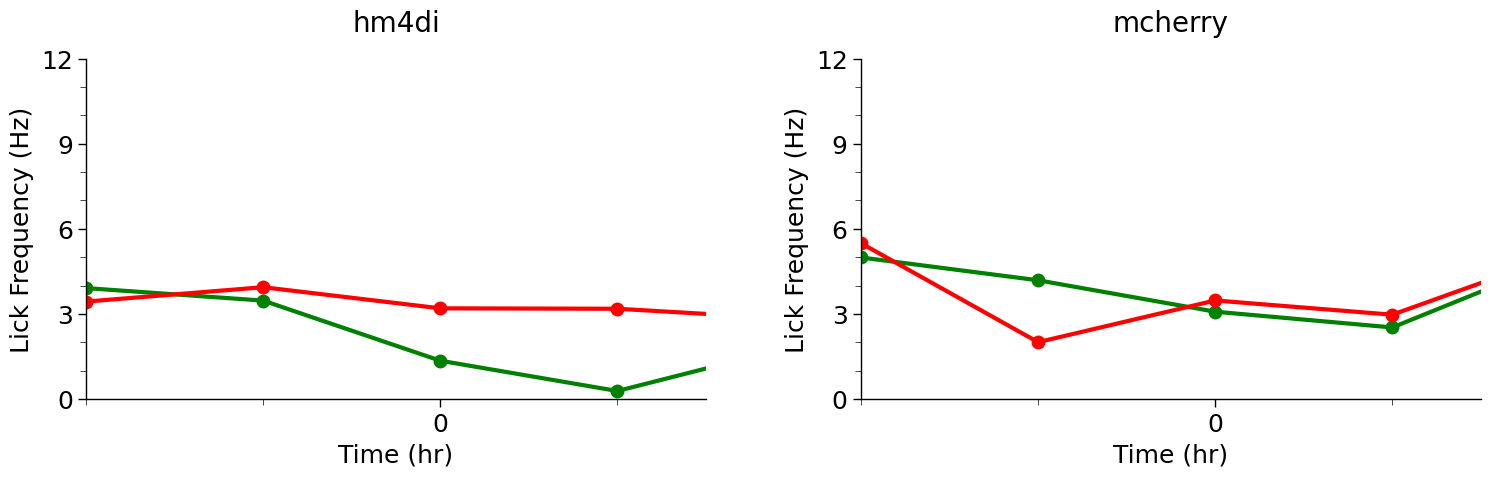

In [84]:
#plot_ant_lickfreq(ant_mean_statistics, legend=False, ylim=[0,8], xlim=[-8, 8])
plot_ant_lickfreq(ant_mean_statistics, legend=False, col="depress", ylim=[0,12], xlim=[-8, 6])

Performance (L<sub>stim</sub> - L<sub>blank</sub>) as a line plot and a bar plot

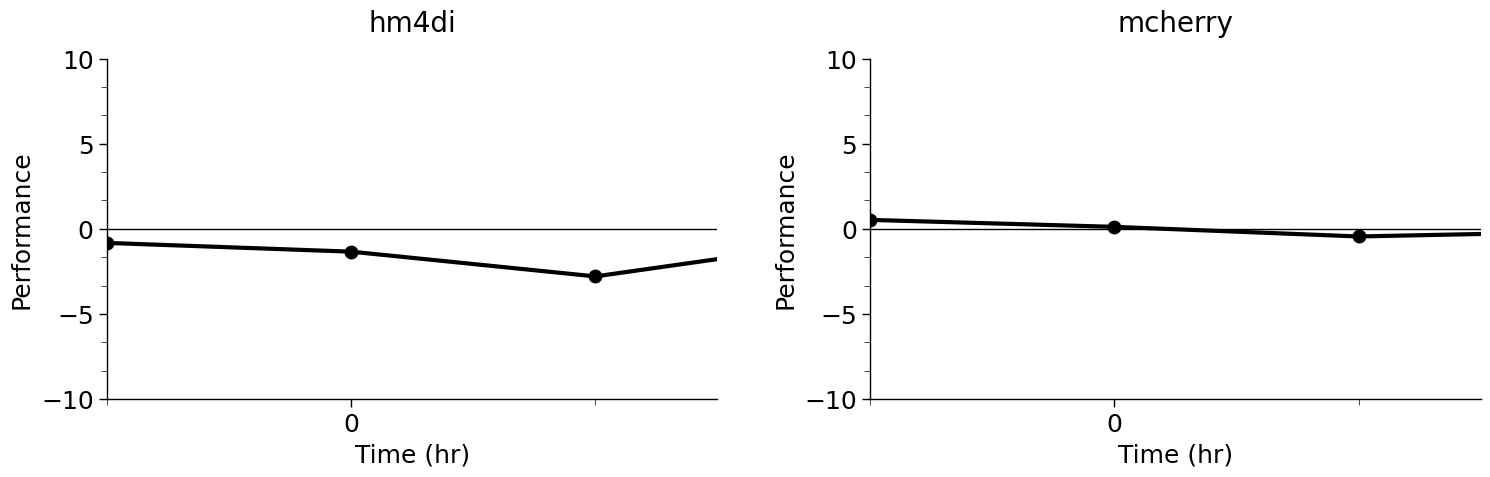

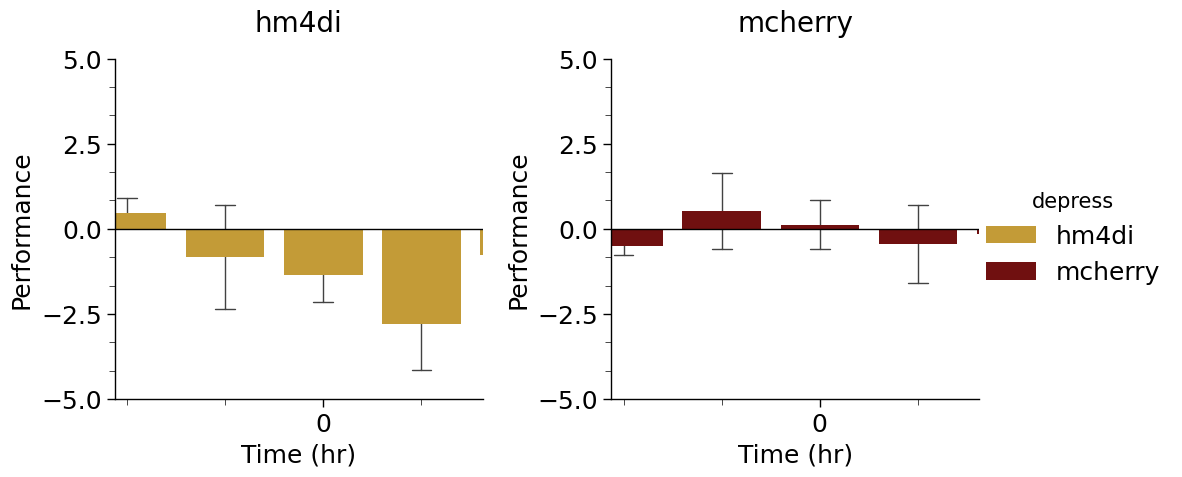

In [85]:
#plot_ant_perf(ant_perf, ylabel="Performance", xlim=[-48, 48])
plot_ant_perf(ant_perf, ylabel="Performance", xlim=[-4, 6], col="depress")

# using a palette to color different conditions
p = ["goldenrod", "maroon"]
ordr = ["hm4di", "mcherry"]
ylim=[-5, 5]
plot_ant_perf_bar(ant_perf, ylim=ylim, hue="depress", palette=p, xlim=[-8.5,6.5], 
                  col="depress", hue_order=ordr)

Number of trials by time bin

In [86]:
th = total_by_hour[(total_by_hour["Time (hr)"] < 6) & (total_by_hour["Time (hr)"] >= -8)]
th.groupby(["depress", "Time (hr)"])["trial no"].mean().unstack(level="Time (hr)")

Time (hr),-8.0,-4.0,0.0,4.0
depress,,,,
hm4di,88.000000,37.000000,12.818182,23.363636
mcherry,78.285714,14.142857,9.571429,31.428571


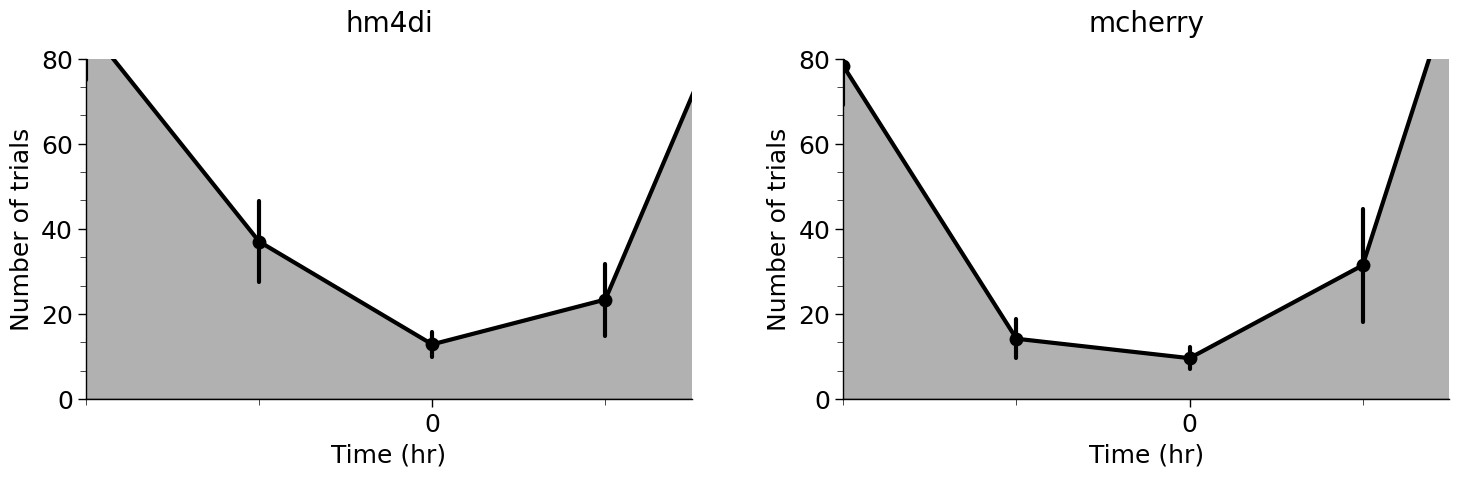

In [87]:
plot_trial_hr(total_by_hour, xlim=[-8, 6], col="depress", ylim=[0, 80])

Last 20% of trials 

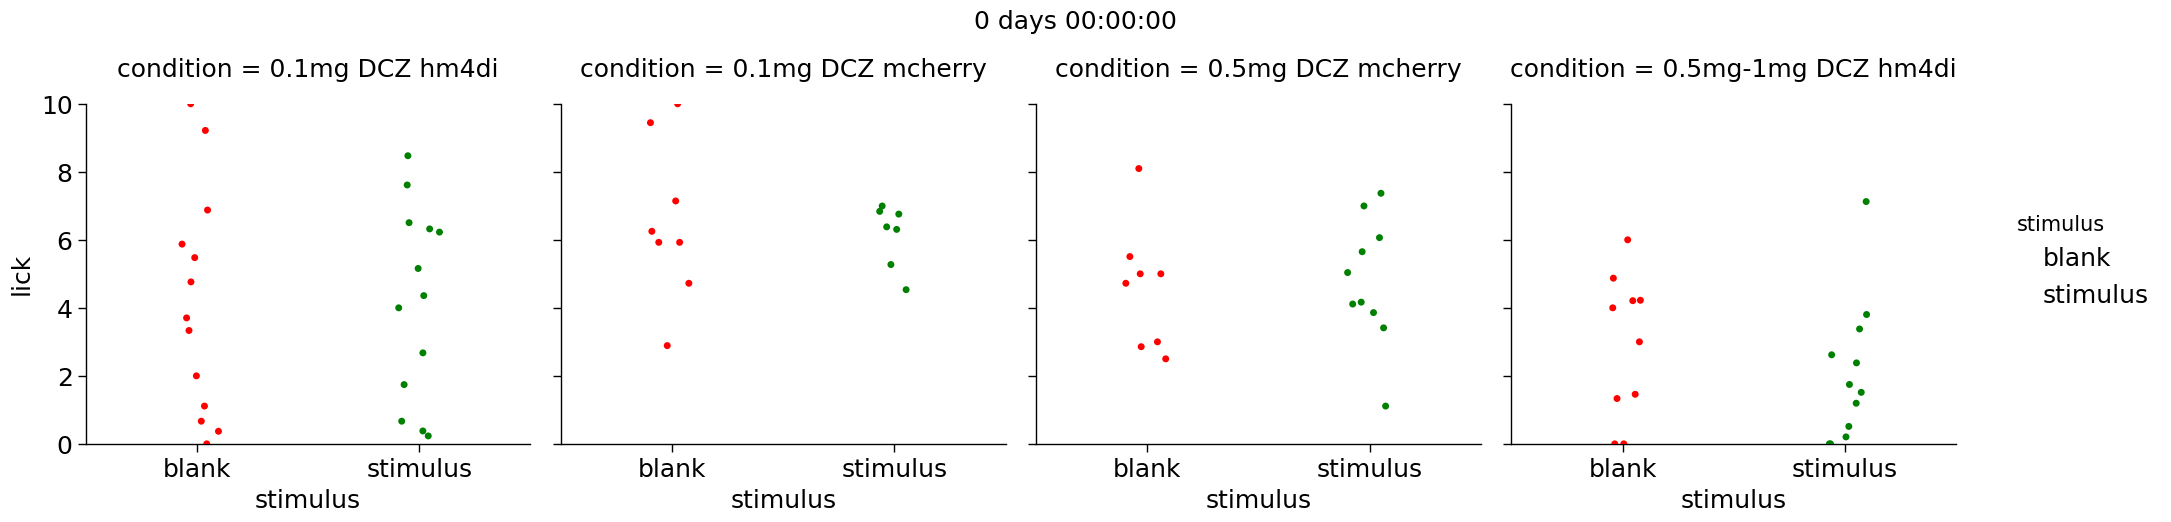

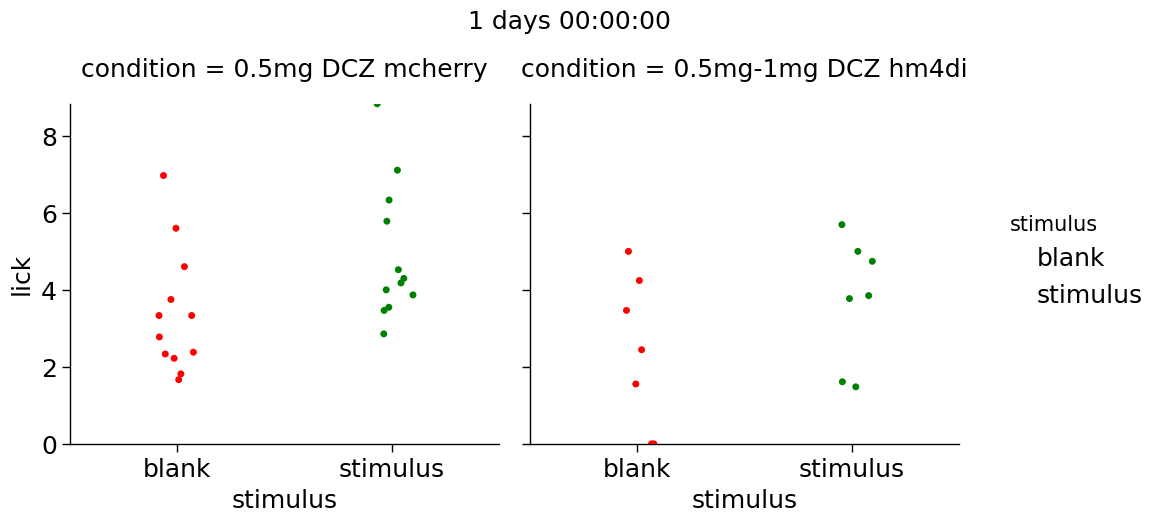

In [88]:
# TODO: incorrect because of incorrect aggregation
for day in last20_lickfreq["day_delta"].unique():
    if day >= pd.to_timedelta(0):
        g = sns.catplot(last20_lickfreq[last20_lickfreq["day_delta"] == day], 
                    y="lick",x="stimulus", kind="strip", hue="stimulus", 
                    palette=["red", "green"], hue_order=["blank", "stimulus"],
                    col="condition")
        g.figure.suptitle(day, y=1.05)

Number of trials by trial type

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 23 and the array at index 1 has size 24

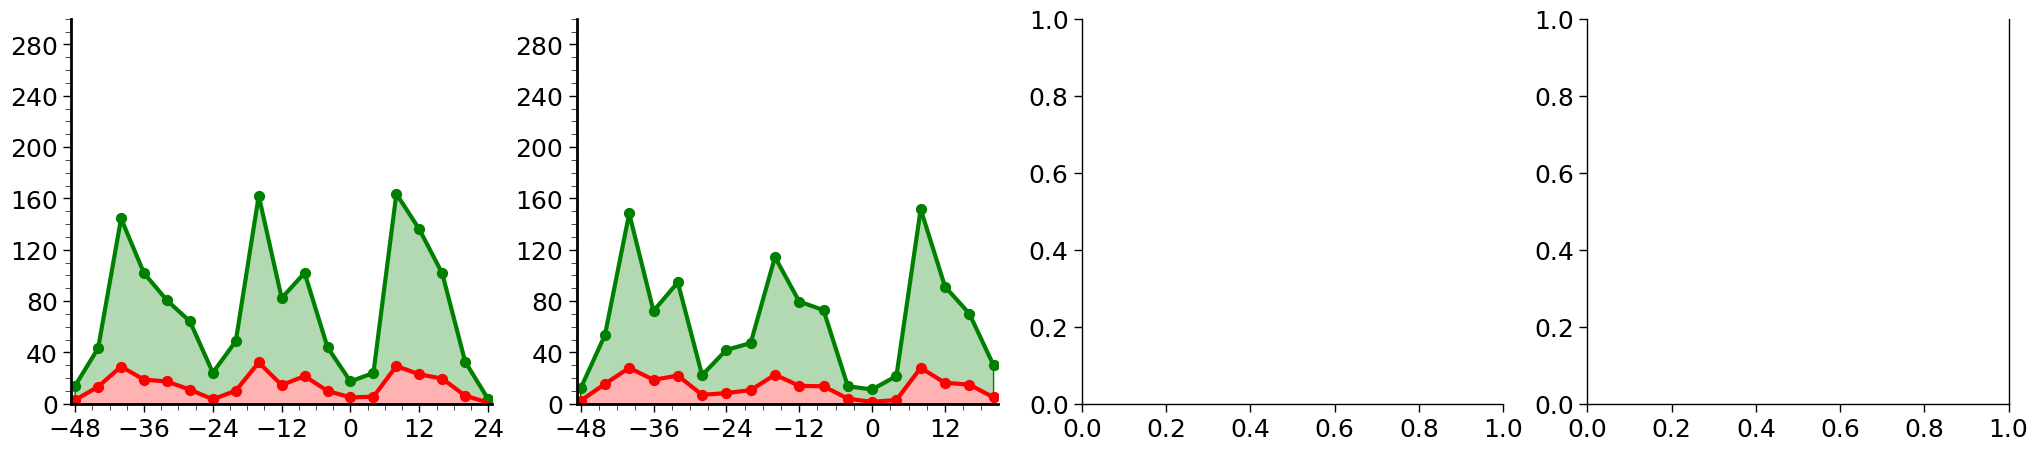

In [89]:
# number of stimulus and blank trials as stacked plot (average but no error bars)
avg_counts = counts.groupby(["condition", "Time (hr)", "stimulus"])["trial no"].mean().reset_index()

conds = avg_counts["condition"].unique()
g, axs = plt.subplots(1, len(conds), figsize=(25,5))


ylims = [0, 300]
ymax = ylims[1]

for i in range(len(conds)):
    lab = avg_counts[avg_counts["condition"] == conds[i]]["stimulus"].unique()
    x = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["Time (hr)"]
    axs[i].spines[["top", "right"]].set_visible(False)
    y1 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["trial no"].reset_index(drop=True)
    y2 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[1])]["trial no"].reset_index(drop=True)
    axs[i].stackplot(x, y1, y2, labels=lab, colors=['#FFB2B2','#B2D9B2'], alpha=1, edgecolor=["green", "red"])
    axs[i].plot(x, y1, color="red")
    axs[i].scatter(x, y1, color="red", s=50)
    axs[i].plot(x, (y1 + y2),color="green")
    axs[i].scatter(x, (y1 + y2), color="green",s=50)    
    ylabel="Number of trials"
    axs[i].set_ylim(ylims)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(12))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(40))
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(3))
    axs[i].yaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].spines[["bottom", "left"]].set(lw=2)
g.subplots_adjust(wspace=0.25)

### 2.1.4 Statistical Tests

Total number of trials between groups (should not be significantly different)

t-test if two conditions, ANOVA otherwise

In [ ]:
res = []
for day in total_by_day["Day"].unique(): 
    tt_separated = []
    for c in total_by_day["condition"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["condition"] == c)]["trial no"])
    if len(total_by_day["condition"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["condition"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["Day"].unique())

,statistic,pvalue
ACC 1,0.493112,0.694297
ACC 2,1.165496,0.363341
SAT 1,2.591970,0.094066
SAT 2,NaN,NaN


Total number of trials across days (should not be significantly different)

t-test if only 2 days, ANOVA otherwise

In [ ]:
res = []
for c in total_by_day["condition"].unique(): 
    tt_separated = []
    tmp = total_by_day[total_by_day["condition"] == c]
    for day in tmp["Day"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["condition"] == c)]["trial no"])
    if len(total_by_day["Day"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["Day"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
        
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["condition"].unique())

,statistic,pvalue
0.1mg DCZ hm4di,3.016497,0.071827
0.1mg DCZ mcherry,0.080172,0.923930
0.5mg DCZ mcherry,0.365977,0.778868
0.5mg-1mg DCZ hm4di,1.886461,0.185707


Last 20% of trials for all days of SAT

In [ ]:
# TODO: incorrect because of incorrect aggregation
res = []

stimcond = last20_lickfreq["stimulus"] == "stimulus"
blankcond = last20_lickfreq["stimulus"] == "blank"

days = last20_lickfreq["day_delta"].unique()
days = days[days >= pd.to_timedelta(0)]

conds = last20_lickfreq["condition"].unique()

ind = last20_lickfreq[last20_lickfreq["day_delta"] >= pd.to_timedelta(0)][["day_delta", "condition"]].apply(tuple, axis=1).unique()

for day, c in ind:
    daycond = last20_lickfreq["day_delta"] == day
    ccond = last20_lickfreq["condition"] == c
    stim = last20_lickfreq[stimcond & daycond & ccond]["lick"]
    blank = last20_lickfreq[blankcond & daycond & ccond]["lick"]
    res.append(stats.ttest_ind(stim, blank, equal_var=False))

pd.DataFrame(res, columns=["statistic", "pvalue"], index=pd.Series(ind).apply(lambda x: x[1] + ", " + str(x[0])))

,statistic,pvalue
"0.1mg DCZ hm4di, 0 days 00:00:00",0.061373,0.951582
"0.1mg DCZ mcherry, 0 days 00:00:00",0.132917,0.897405
"0.5mg DCZ mcherry, 0 days 00:00:00",0.878249,0.395329
"0.5mg DCZ mcherry, 1 days 00:00:00",2.177101,0.040570
"0.5mg-1mg DCZ hm4di, 0 days 00:00:00",-0.502767,0.621235
"0.5mg-1mg DCZ hm4di, 1 days 00:00:00",1.390149,0.190611


## 2.2 Lick frequency for entire trial


If `freq_window` is not `None` data will be averaged with a rolling window of the
given length. Data will then be averaged into discrete time bins the legnth of
`freq_bin`. If `freq_bin` is the rate at which data is sampled (every 100ms),
then instentaneous lick frequency will be averaged across animals. 

Parameters

In [ ]:
freq_window = None # milliseconds, length of rolling window
freq_bin = 100 # milliseconds, length of discrete time bin
time_bin = 4*60
min_trials = 5

### 2.2.1 Analysis

In [ ]:
data = lickfreq_analysis(df, freq_window, freq_bin, time_bin)

In [ ]:
mean_statistics, counts, perf = aggregate_analysis(data, min_trials, min_blank_trials, min_water_trials, ["day_delta", "type"])

### 2.2.2 Plotting

Instentaneous licking frequency for stimulus and blank trials for entire trial

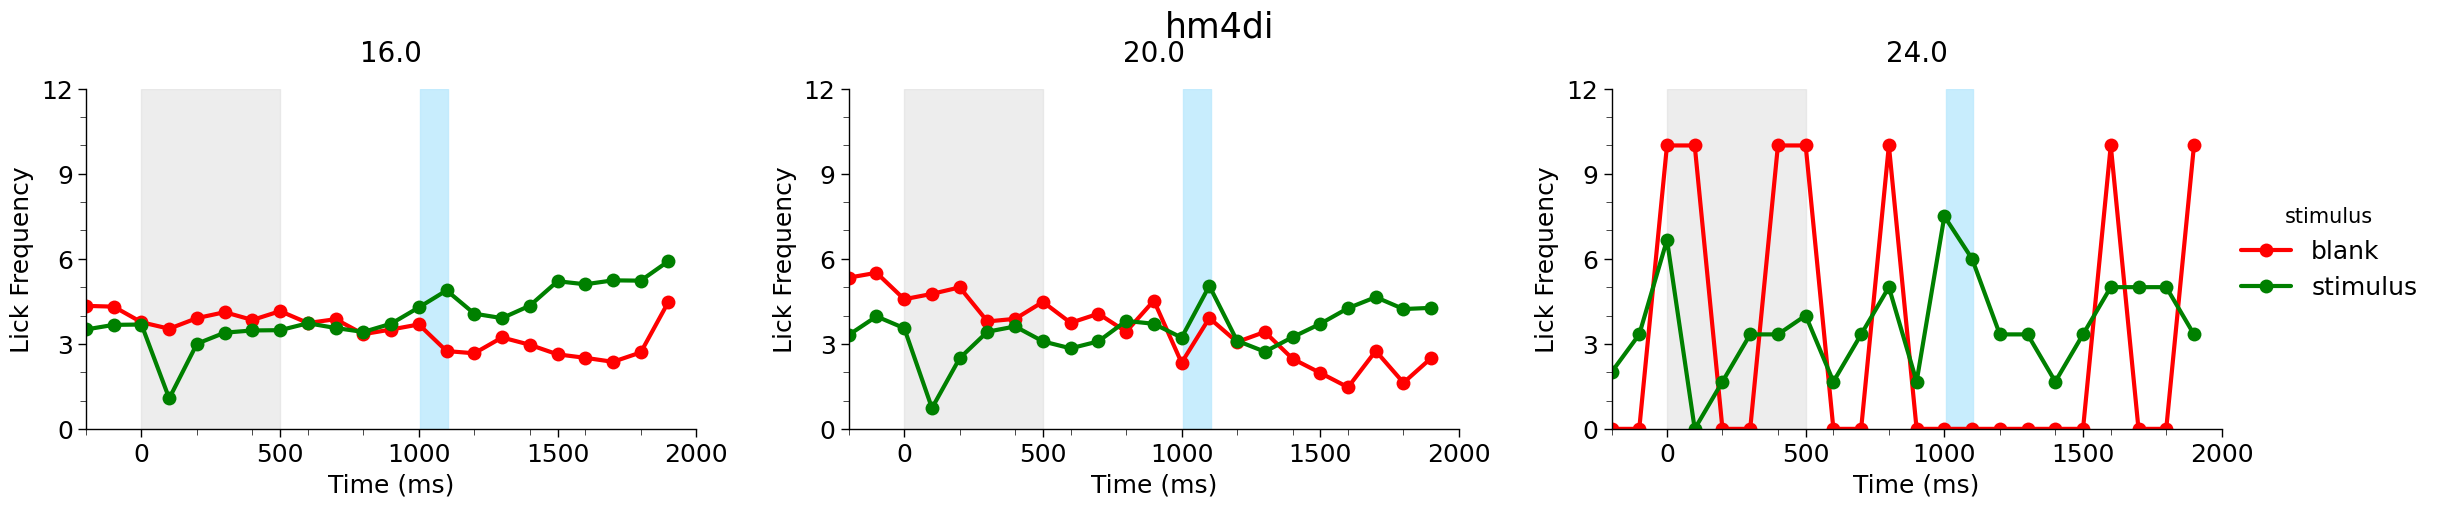

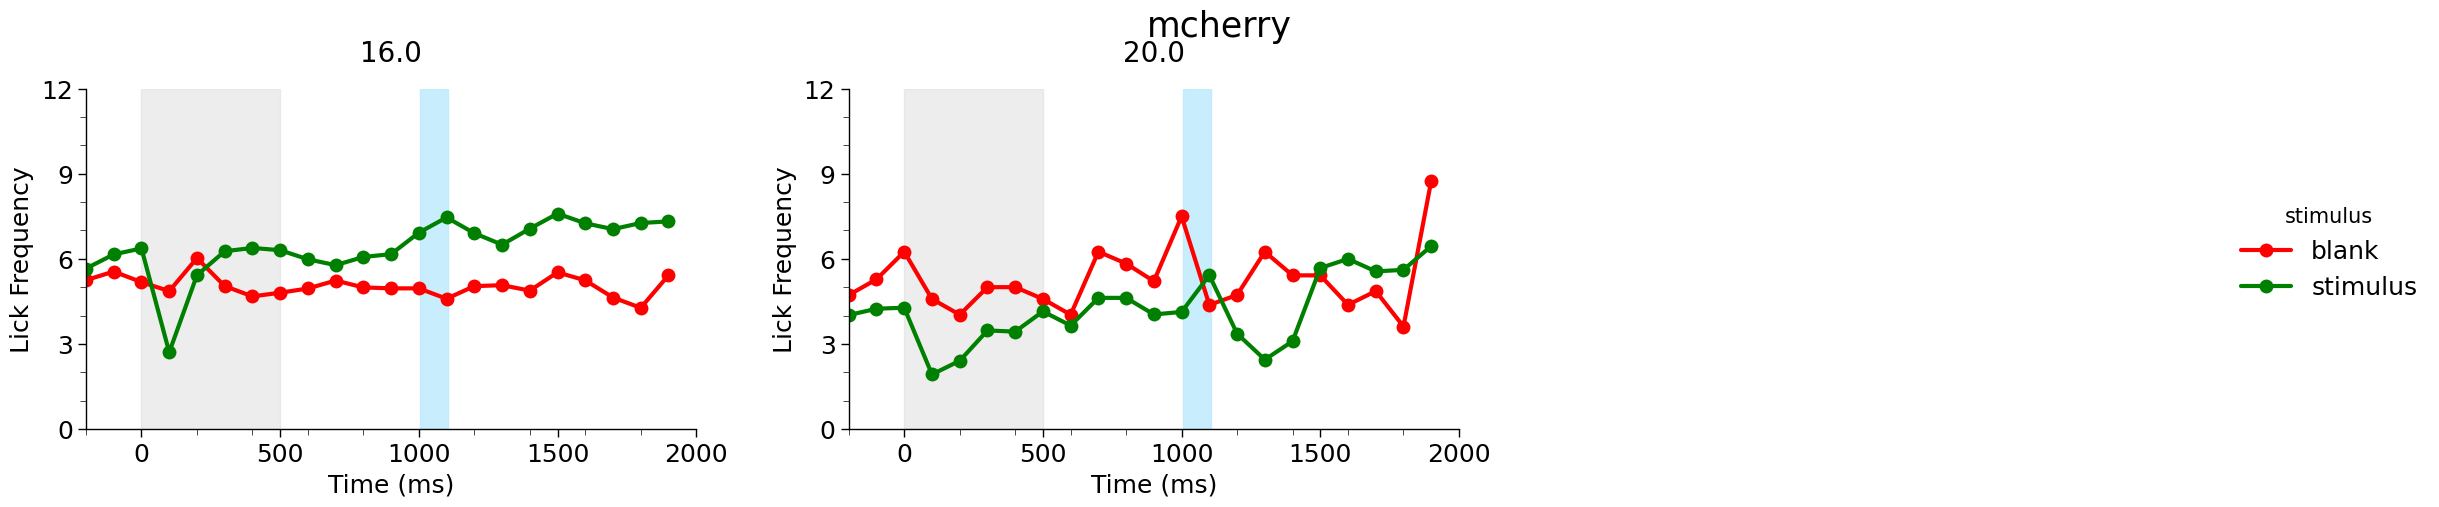

In [ ]:
mean_statistics["depress"] = mean_statistics["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})
cond = (mean_statistics["Time (hr)"] <= 24) & (mean_statistics["Time (hr)"] >= 16)
p=["red", "green"]
ordr=["blank", "stimulus"]
for condition in mean_statistics["depress"].unique(): 
    plot_data = mean_statistics[cond & (mean_statistics["depress"] == condition)]
    plot_lickfreq(plot_data, suptitle=condition, hue="stimulus", hue_order=ordr, 
                  palette=p, col_wrap=3)

Performance (L<sub>stim</sub> - L<sub>blank</sub>) for entire trial, comparing
timebins together across groups

In [ ]:
time_bin = 4*60
data = lickfreq_analysis(df, freq_window, freq_bin, time_bin)
mean_statistics, counts, perf = aggregate_analysis(data, min_trials, min_blank_trials, min_water_trials, ["day_delta", "type"])

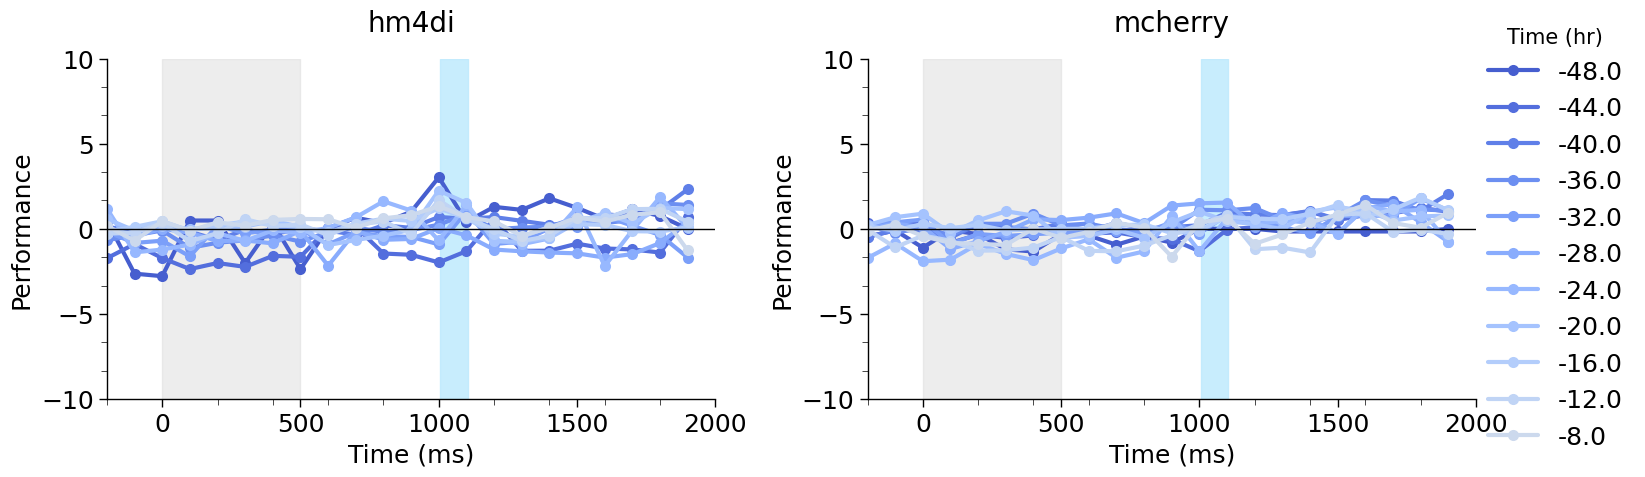

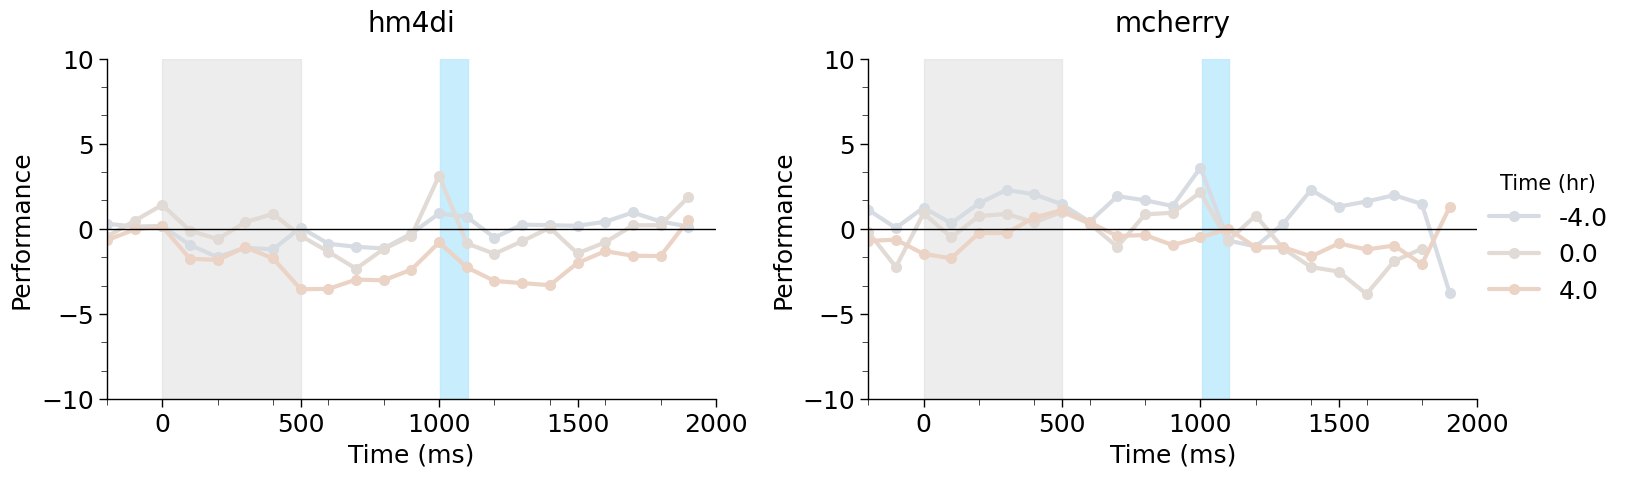

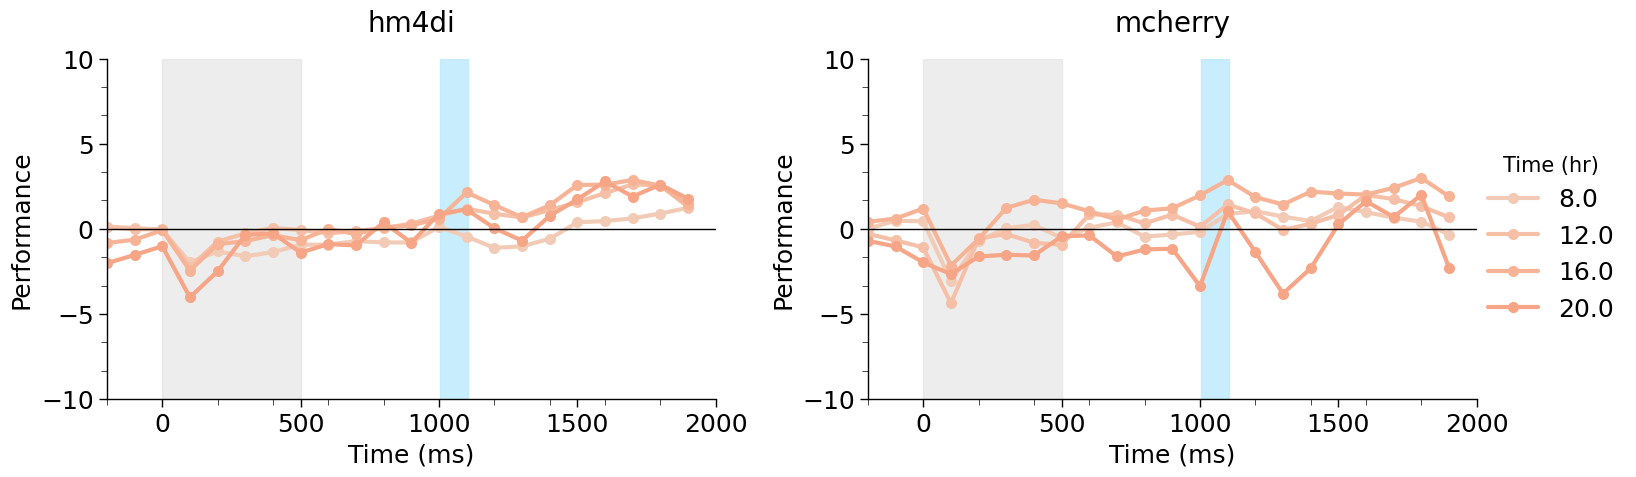

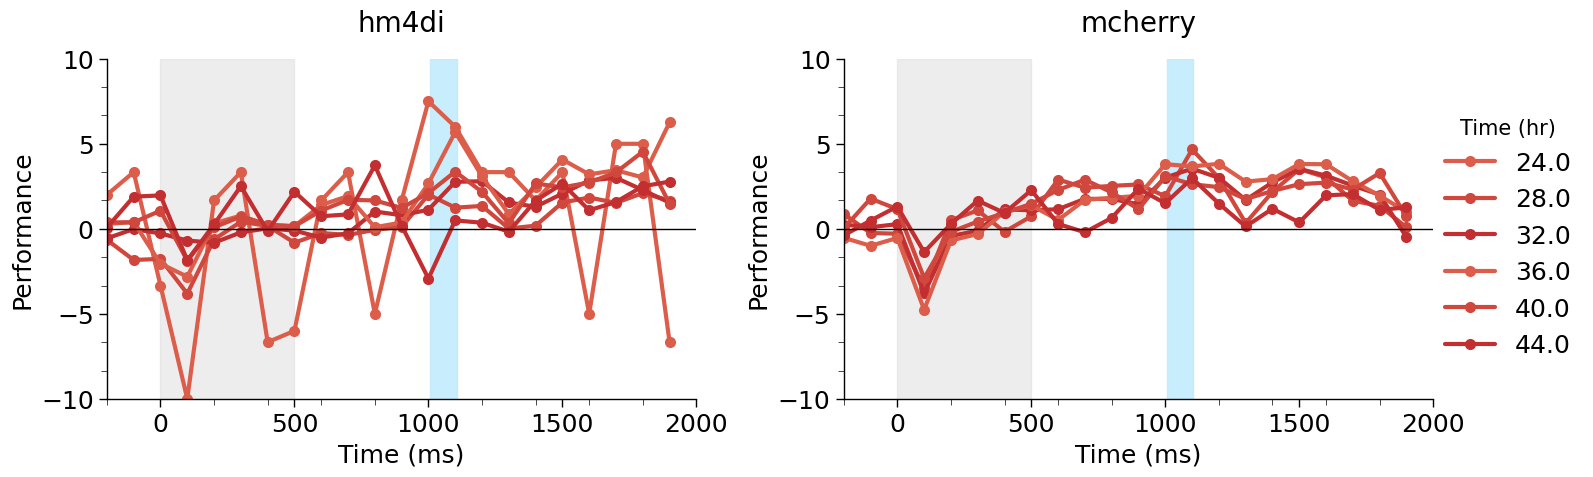

In [ ]:
acc = ( (perf["Time (hr)"] < -4) )
early = ( (perf["Time (hr)"] < 8) & (perf["Time (hr)"] >= -4) )
late = ( (perf["Time (hr)"] >= 8) & (perf["Time (hr)"] < 24))
later = ( (perf["Time (hr)"] >= 24) )
perf["depress"] = perf["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

# ensures palette is centered around 0
num_bins = (len(perf[acc]["Time (hr)"].unique()) + 1) * 2
pl = sns.color_palette("coolwarm", n_colors=num_bins)

# 12 4h bins in ACC48 
plot_perf(perf[acc], palette=pl[0:11],ms=8, col="depress")

# first 2 SAT timebins (SAT8)
plot_perf(perf[early], palette=pl[11:14],ms=8, col="depress")

# rest of SAT
plot_perf(perf[late], palette=pl[14:21],ms=8, col="depress")

plot_perf(perf[later], palette=pl[21:],ms=8, col="depress")


Performance (L<sub>stim</sub> - L<sub>blank</sub>) for entire trial, comparing
groups together across timebins

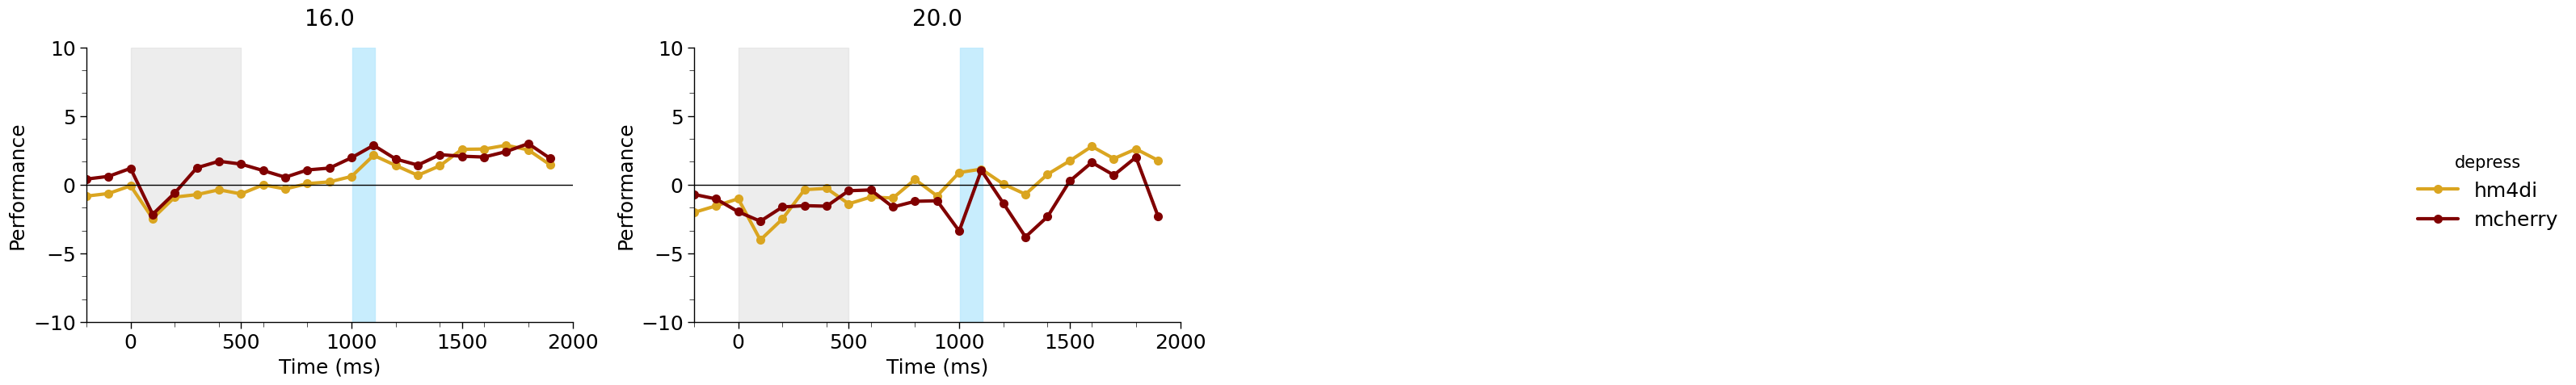

In [ ]:
p = ["goldenrod", "maroon"]
ordr=["hm4di", "mcherry"]
perf["depress"] = perf["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

cond = (perf["Time (hr)"] <= 20) & (perf["Time (hr)"] >= 16)

plot_perf(perf[cond], col="Time (hr)", hue="depress", ms=8, palette=p, col_wrap=4)

## 2.3 Lick frequency during Puff

### 2.3.1 Lick frequency analysis

In [ ]:
r = (0, 300)
puff_data = bin_lickfreq_analysis(df, r, time_bin)

In [ ]:
puff_mean_statistics, puff_counts, puff_perf = bin_aggregate_analysis(puff_data, min_trials, min_blank_trials, min_water_trials, ["type"])

### 2.3.2 Plotting

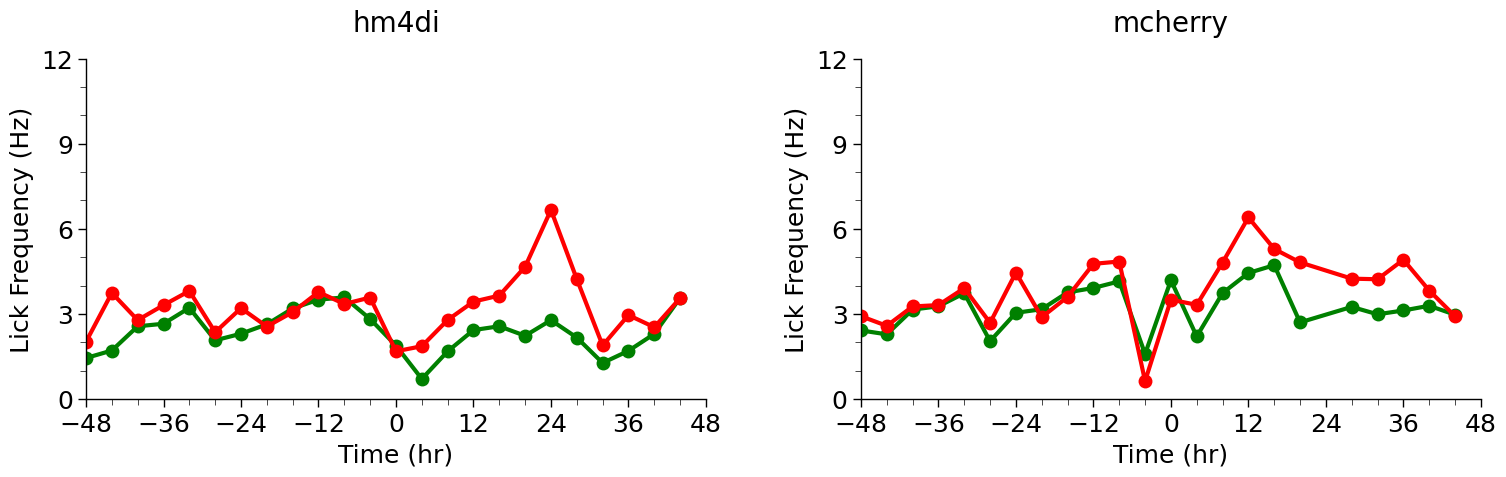

In [ ]:
puff_mean_statistics["depress"] = puff_mean_statistics["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

plot_ant_lickfreq(puff_mean_statistics, legend=False, xlim=[-48, 48], col="depress")

## 2.4 Bout analysis


Bout boundaries are defined as 2 consecutive trials being more than 2 minutes
apart, based on visual investigation of raster plots of 
trial distributions of individual animals.

### 2.4.1 Analysis

In [ ]:
r = (-200, 0)
ant_data = bin_lickfreq_analysis(df, r, time_bin)
ant_mean_statistics, counts, ant_perf = bin_aggregate_analysis(ant_data, min_trials, min_blank_trials, min_water_trials, ["Day", "day_delta", "type"])
data = get_bouts(ant_data, ["animal"], "timestamp", "bout no", 2, "min")

In [ ]:
# calculate bout statistics

# metadata
keep = data.groupby(["animal", "bout no"]).last()[["condition", "age", "sex", "strain", "cage", "Time (hr)", "stimulus"]]

# bout length (time of last sample in bout - time of first sample in bout)
bout_start = data.groupby(["animal", "bout no"]).first()["timestamp"] 
bout_end = data.groupby(["animal", "bout no"]).last()["timestamp"]
bout_end_identity = data.groupby(["animal", "bout no"]).last()[["timestamp","stimulus"]]
bout_len = (bout_end - bout_start).rename("bout len")

# intra bout iti (first sample of trial - last sample of previous trial)
intra_bt_trial_start = data.groupby(["animal", "bout no", "trial no"]).first()["timestamp"]
intra_bt_trial_end = data.groupby(["animal", "bout no", "trial no"]).last()["timestamp"]
intra_bt_iti = (intra_bt_trial_start - intra_bt_trial_end.groupby(["animal", "bout no"]).shift()).rename("intra bout iti")
intra_bt_iti = intra_bt_iti.groupby(["animal", "bout no"]).mean()
num_trials = intra_bt_trial_start.groupby(["animal", "bout no"]).count().rename("num trials")

# inter bout interval (first sample in bout - last sample in previous bout)
ibi = (bout_start - bout_end.groupby(["animal"]).shift()).rename("ibi")

# concat stats and metatdata together
bout_stats = pd.concat([keep, bout_len, ibi, intra_bt_iti, num_trials], axis=1).reset_index()

# convert to float
# handle NaT (i.e. first trial in bout for iti and ibi) by setting to -1 then 
# resetting all values less than 1 to NA 
# (hacky, but works because no iti or ibi should ever be < 0)
bout_stats["bout len"] = bout_stats["bout len"].to_numpy(dtype="timedelta64[ms]").astype("float")/(1000.)
bout_stats["ibi"] = bout_stats["ibi"].to_numpy(dtype="timedelta64[m]", na_value=-1).astype("float")/60.
bout_stats.loc[bout_stats["ibi"] < 0,"ibi"] = pd.NA
bout_stats["intra bout iti"] = bout_stats["intra bout iti"].to_numpy(dtype="timedelta64[ms]", na_value=-1).astype("float")/1000.
bout_stats.loc[bout_stats["intra bout iti"] < 0,"intra bout iti"] = pd.NA

# calculate trial frequency (number of trials/length of bout)
bout_stats["frequency"] = bout_stats["num trials"]/bout_stats["bout len"]

### 2.4.2 Plotting

Bout length

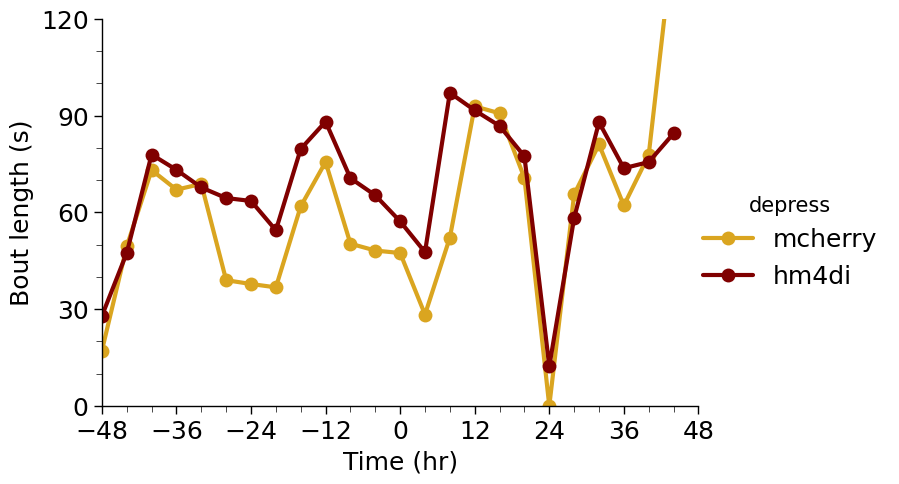

In [ ]:
p = ["goldenrod", "maroon"]
ordr=["hm4di", "mcherry"]
bout_stats["depress"] = bout_stats["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

plot_hr(bout_stats, y="bout len", col=None, hue="depress",
              ylim=[0, 120], xlim=[-48, 48],palette=p, ylabel="Bout length (s)")

Inter bout interval

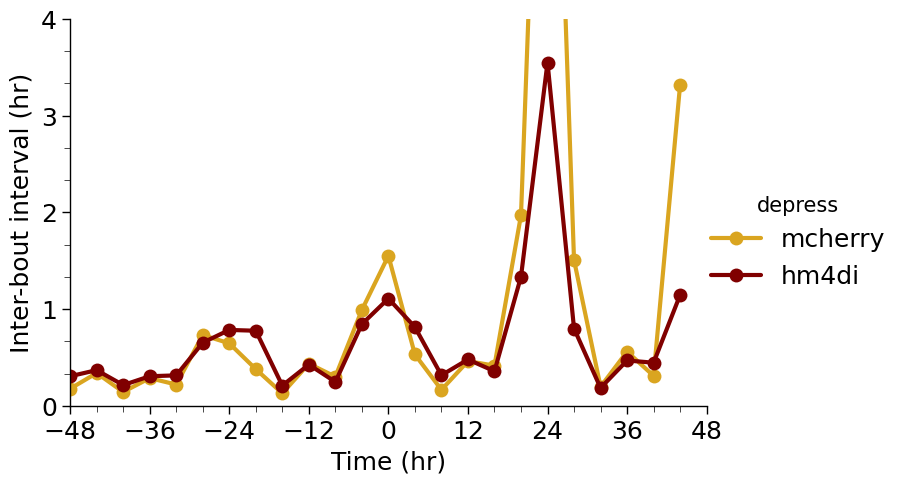

In [ ]:
plot_hr(bout_stats, y="ibi", hue="depress", col=None, 
              ylim=[0, 4],xlim=[-48, 48], palette=p, ylabel="Inter-bout interval (hr)")

Intra-bout inter trial interval

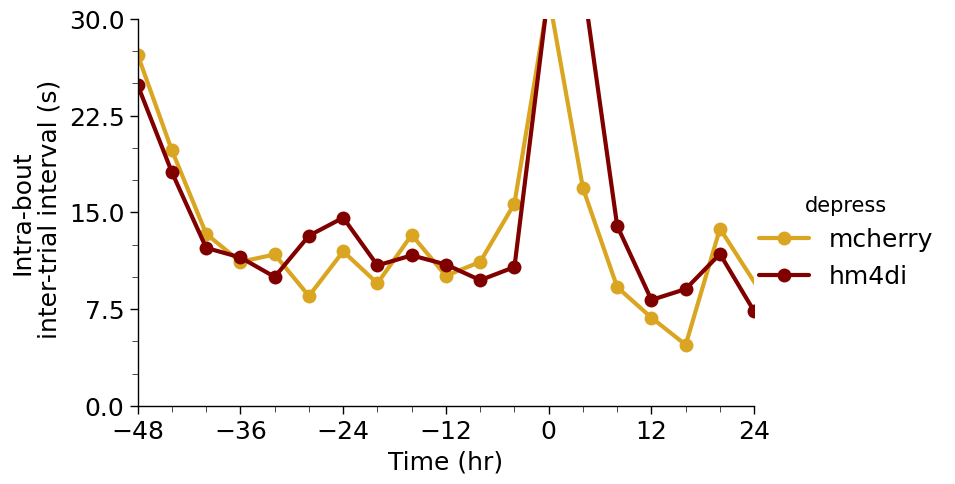

In [ ]:
plot_hr(bout_stats, y="intra bout iti", hue="depress", col=None, 
              ylim=[0, 30], palette=p,ylabel="Intra-bout\n inter-trial interval (s)" )

Number of trials per bout

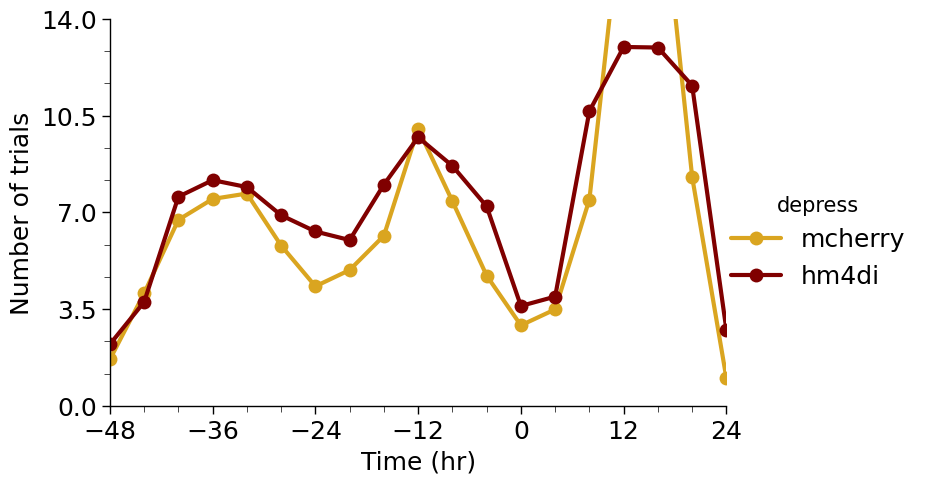

In [ ]:
plot_hr(bout_stats, y="num trials", hue="depress", col=None, 
              ylim=[0, 14], palette=p, ylabel="Number of trials")

Intra-bout trial frequency

In [ ]:
plot_hr(bout_stats, y="frequency", hue="depress", col=None, 
              ylim=[0, 0.5], palette=p, ylabel="Intra-bout trial frequency\n(trials/s)")

: 

## 2.5 Anticipatory licking based on previous trial identity

Splitting data based on whether the previous trial was stimulus or blank. 
Using bout labeling to ensure that previous trials are consecutive.

### 2.5.1 Analysis

In [ ]:
trial_ind = ["animal", "trial no"]
bout_ind = ["animal", "bout no"]
key = "stimulus"
n = 1
cond0 = "stimulus"
cond1 = "blank"
data = get_n_back(data, trial_ind, bout_ind, key, n, cond0, cond1)

untested for `n` $\geq$ `1`

In [ ]:
def agg_by_prev_trial(data, agg_data, n, min_trials, min_blank_trials, min_water_trials, keep):
    mean_statistics, counts, perf = agg_data
    mean_statistics["n_back"] = 0
    counts["n_back"] = 0
    perf["n_back"] = 0

    mean_statistics["back_type"] = "none"
    counts["back_type"] = "none"
    perf["back_type"] = "none"

    for i in range(1, n+1):
        cname = f'{i}_back'
        stimcond = data[cname] == "stimulus"
        bcond = data[cname] == "blank"
        for j in range(1, i):
            cname = f'{j}_back'
            stimcond = stimcond & (data[cname] == "stimulus")
            bcond = bcond & (data[cname] == "blank")
        prev_stim = data[data[cname] == "stimulus"]
        prev_blank = data[data[cname] == "blank"]

        ps_data = bin_aggregate_analysis(prev_stim, min_trials, min_blank_trials, 
                                     min_water_trials, keep)
        ps_data = set_prev_info(ps_data, i, "stimulus")
        ps_mean, ps_counts, ps_perf = ps_data
        

        pb_data = bin_aggregate_analysis(prev_blank, min_trials, min_blank_trials, 
                                     min_water_trials, keep)
        pb_data = set_prev_info(pb_data, i, "blank")
        pb_mean, pb_counts, pb_perf = pb_data
        

        mean_statistics = pd.concat([mean_statistics, ps_mean, pb_mean])
        counts = pd.concat([counts, ps_counts, pb_counts])
        perf = pd.concat([perf, ps_perf, pb_perf])
        return mean_statistics, counts, perf

In [ ]:
# TODO: increase number of previous trials to label
n = 1
mean_w_prev, counts_w_prev, perf_w_prev = agg_by_prev_trial(data, (ant_mean_statistics, counts, ant_perf), n, min_trials, min_blank_trials, min_water_trials, ["type"])

In [ ]:
# number of trials per bout
f = data.groupby(["condition", "animal", "Time (hr)", "bout no", "trial no"]).first().reset_index()

counts_prev = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus", "1_back"]).count()
cts_gp = counts_prev.groupby(["condition", "animal", "Time (hr)", "stimulus", "1_back"])
mean_prev = cts_gp.mean().reset_index()
total_prev = cts_gp.sum().reset_index()

counts_stim = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus"]).count()
cts_gp = counts_stim.groupby(["condition", "animal", "Time (hr)", "stimulus"])
mean_stim = cts_gp.mean().reset_index()
total_stim = cts_gp.sum().reset_index()

counts_all = f.groupby(["condition","animal", "Time (hr)", "bout no"]).count()
mean_all = counts_all.groupby(["condition", "animal", "Time (hr)"]).mean().reset_index()

### 2.5.2 Plotting

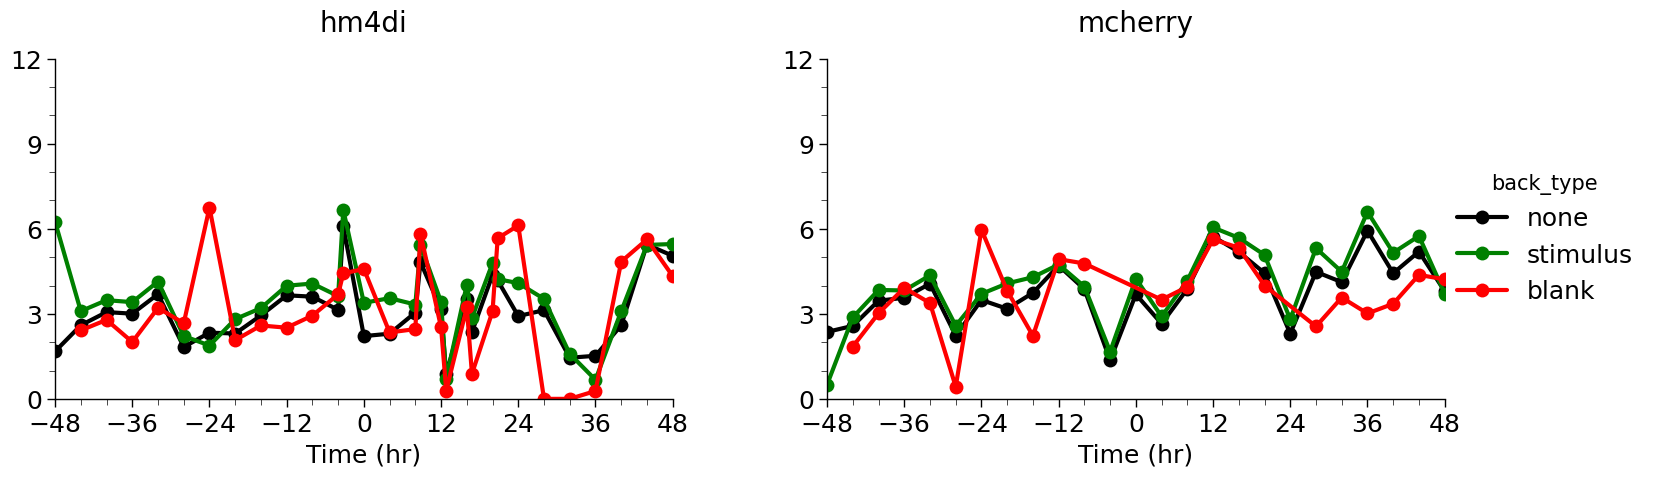

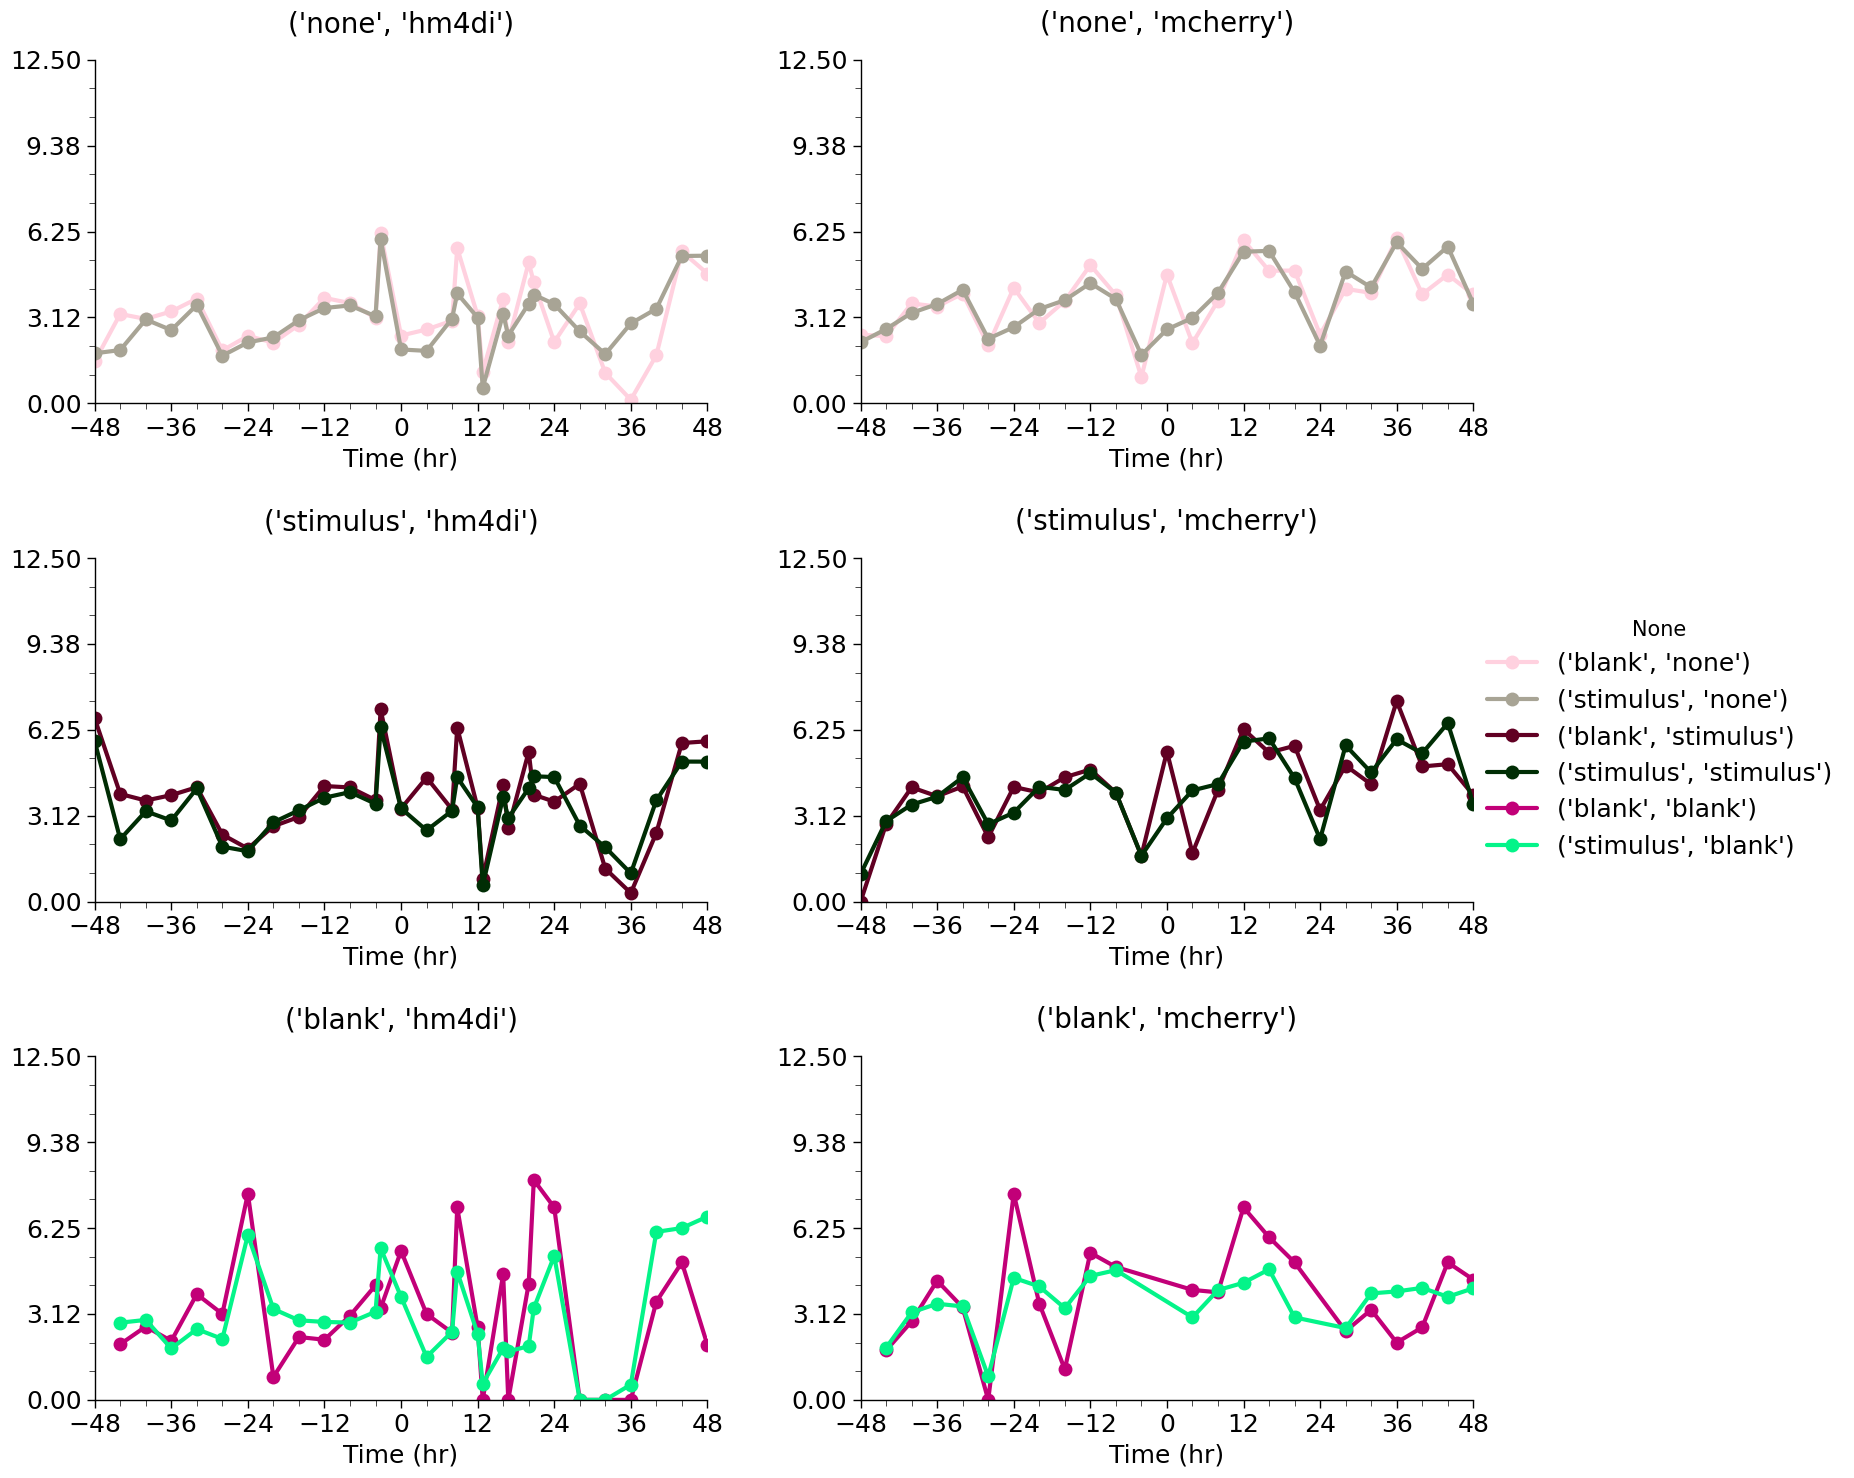

In [ ]:
# anticipatory licking by previous trial contingency
ant = mean_w_prev#[(mean_w_prev["Time (ms)"] == 0)] 
ant["depress"] = ant["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})

h = ant[['stimulus', 'back_type']].apply(tuple, axis=1)
p = ["xkcd:light pink", "xkcd:greyish", 
     "xkcd:burgundy",   "xkcd:dark forest green", 
     "xkcd:magenta",    "xkcd:turquoise green"]
ordr = [('blank', 'none'),     ('stimulus', 'none'), 
        ('blank', 'stimulus'), ('stimulus', 'stimulus'), 
        ('blank', 'blank'),    ('stimulus', 'blank')]

plot_hr(ant, col="depress", hue="back_type", palette=["black", "green", "red"],
        ylim=[0, 12], xlim=[-48, 48])
plot_hr(ant, col="depress", row="back_type", hue=h, palette=p, hue_order=ordr, 
        ylim=[0, 12.5], xlim=[-48,48])

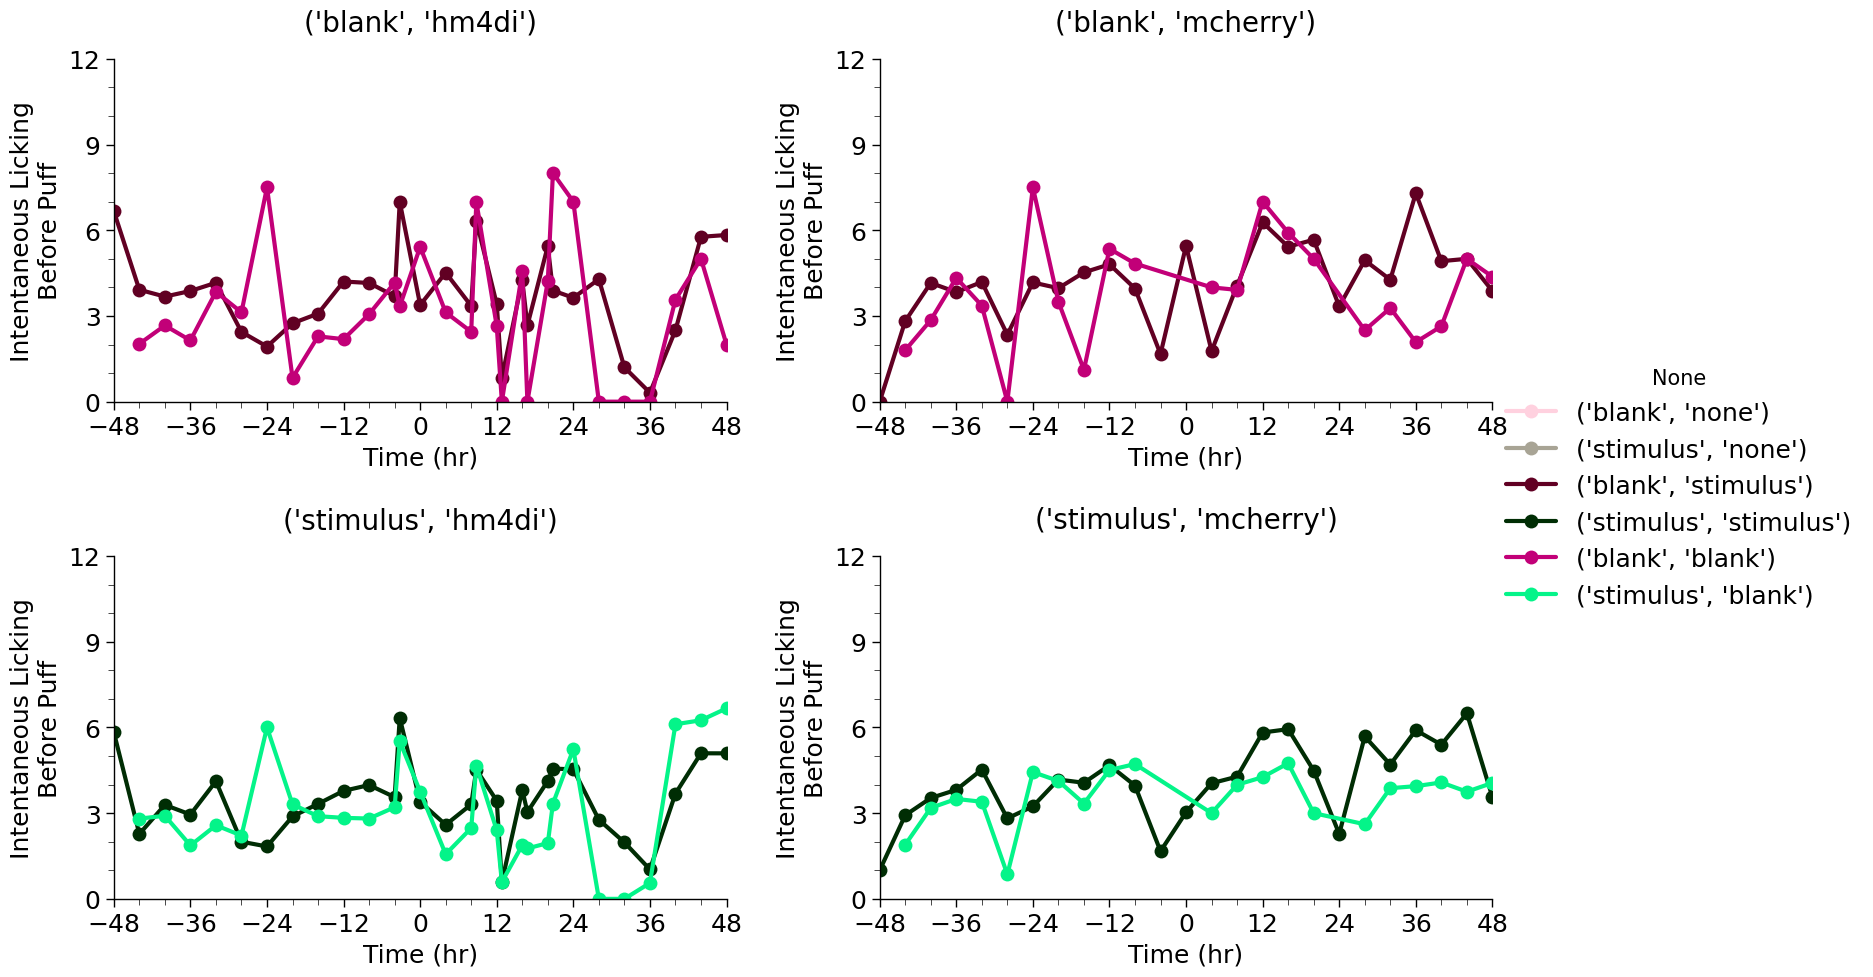

In [ ]:
# anticipstory licking by previous trial contingency blank vs blank and stim vs stim
cond = (ant["n_back"] < 2) & (ant["back_type"] != "none")
h = ant[cond][['stimulus', 'back_type']].apply(tuple, axis=1)

plot_hr(ant[cond], col="depress", row="stimulus", hue=h, palette=p, 
        hue_order=ordr, ylim=[0, 12], ylabel="Intentaneous Licking\nBefore Puff", xlim=[-48, 48])

In [ ]:
mean_w_prev["depress"] = mean_w_prev["condition"].str.contains("hm4di").replace({True:"hm4di", False:'mcherry'})
cond = ( (mean_w_prev["Time (hr)"] <= 48) & (mean_w_prev["Time (hr)"] >= -4) &
       (mean_w_prev["n_back"] < 2) & (mean_w_prev["back_type"] != "none") )

for condition in mean_w_prev["depress"].unique(): 
    plot_data = mean_w_prev[cond & (mean_w_prev["depress"] == condition)]
    h = plot_data[['stimulus', 'back_type']].apply(tuple, axis=1)
    plot_lickfreq(plot_data, suptitle=condition, hue=h, hue_order=ordr, 
                  palette=p)

ValueError: Could not interpret value `Time (ms)` for `x`. An entry with this name does not appear in `data`.

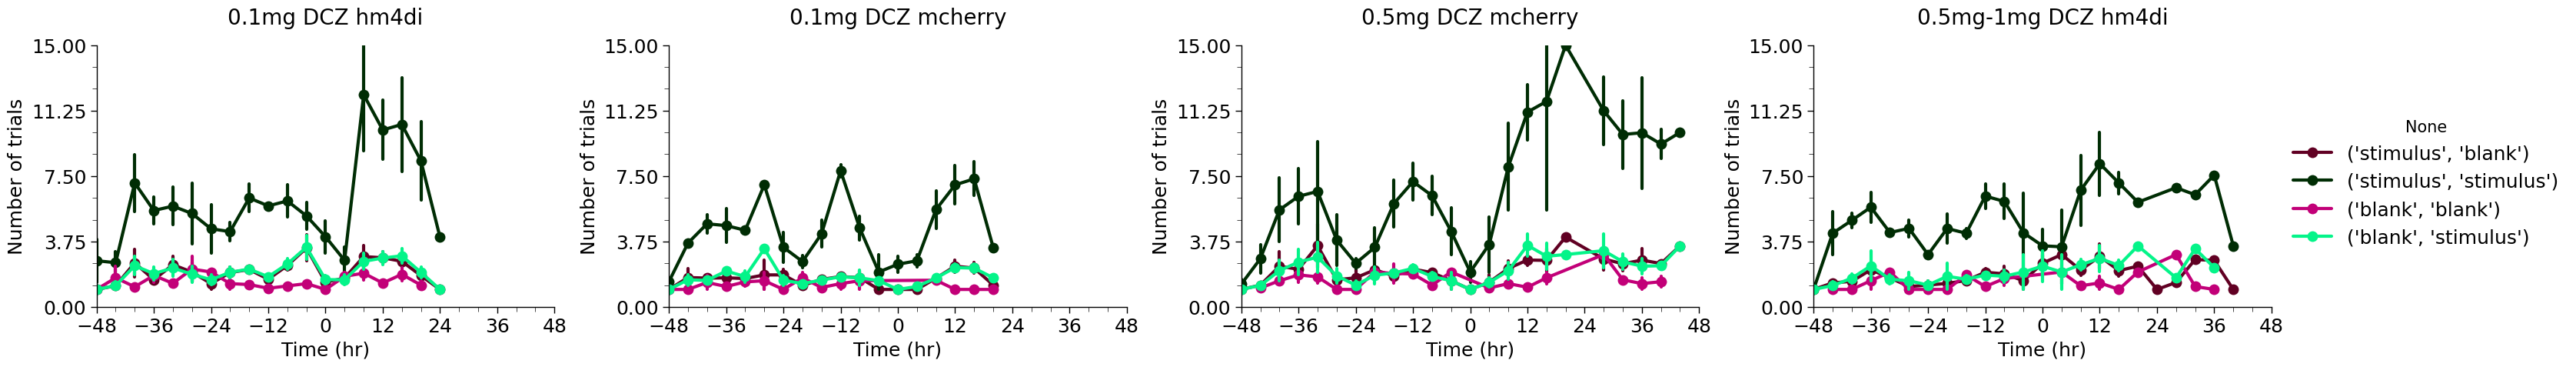

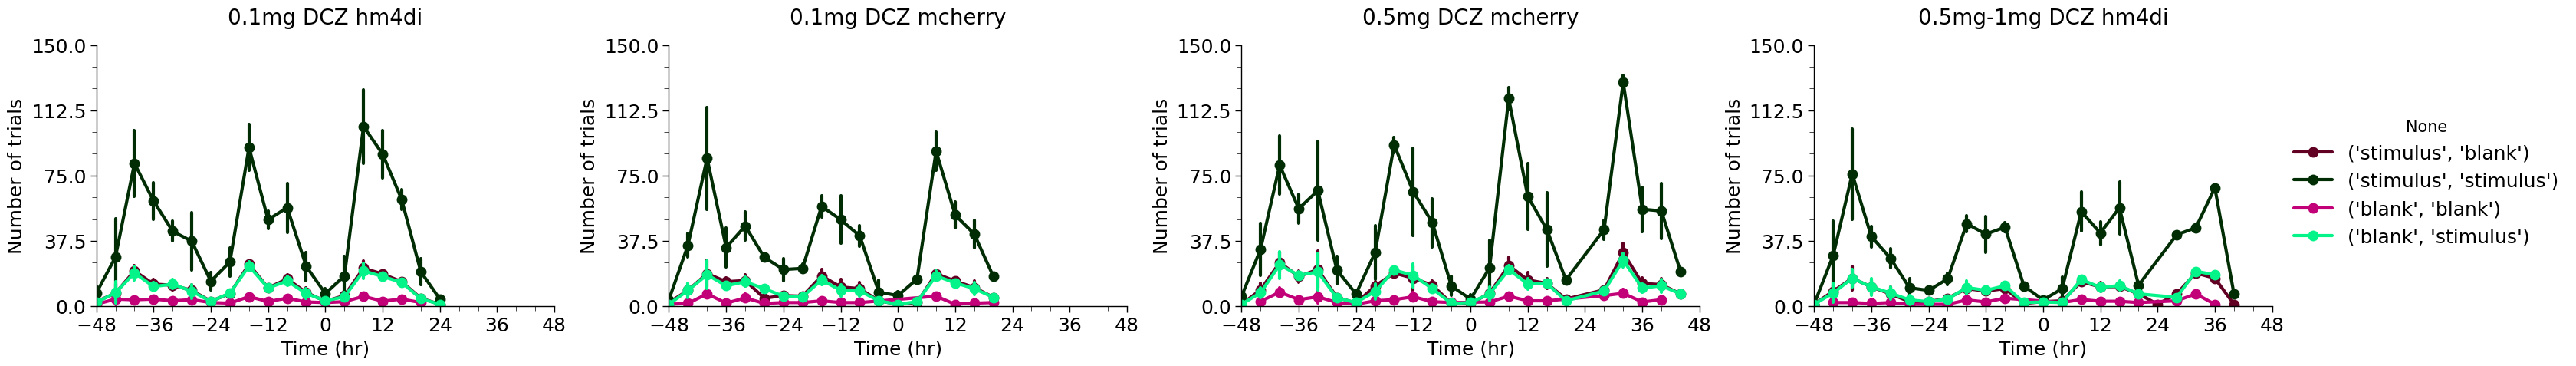

In [ ]:
h = mean_prev[['1_back', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]

# mean number of trials per bin
plot_trial_hr(mean_prev, hue=h, palette=p, hue_order=ordr, ylim=[0, 15], 
              fill=False)

# total number of trials per bin
plot_trial_hr(total_prev, hue=h, palette=p, hue_order=ordr, ylim=[0, 150],
              fill=False)

# 4. Output Results 

This will overwrite any previous output in the same folder, so make sure to 
move files or change the output directory if running the code multiple times.

### 4.1 Aggregate data

In [ ]:
# output_dir = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\refactor_4h'
# cols = ["condition", "animal", "stimulus", "Time (hr)", "Time (ms)", "lick"]
# mean_statistics.to_excel(f'{output_dir}lick_frequency.xlsx', columns=cols, index=False)

# cols = ["condition", "animal", "Time (hr)", "stimulus", "trial no"]
# counts.to_excel(f'{output_dir}trial_counts.xlsx', columns=cols, index=False)

# cols = ["condition", "animal", "Time (hr)", "Time (ms)", "lick"]
# perf.to_excel(f'{output_dir}performance.xlsx', columns=cols, index=False)

# with open(f'{output_dir}parameters.txt', mode='w') as f:
#     out = f'''csv_directory = {csv_directory}
# metadata_file = {metadata_file}
# default_acc_time = {default_acc_time} days

# time_bin = {time_bin} minutes
# freq_window = {freq_window} milliseconds, length of rolling window
# freq_bin = {freq_bin} milliseconds, length of discrete time bin

# min_trials = {min_trials} minimum number of trials in a bin to keep
# min_water_trials = {min_water_trials} minimum number of water trials
# min_blank_trials = {min_blank_trials} minimum number of water trials
# '''
#     f.write(out)

### 4.2 Raw lick frequency data

Takes a long time to run due to large number of samples 
(there are ~40k rows per animal)

In [ ]:
# raw data has too many lines to output to excel
# large number of samples means this takes a long time (~6s for 4 animals)
data.to_csv(f'{output_dir}rawlickfrequency.csv', index=False)

NameError: name 'output_dir' is not defined

# 5. Pipeline description

__Pipeline:__

>```
>raw data (csv) ------------|    loader.py                                                     lickfreq_analysis                                            
>                            |------------------> formatted data - many animals (dataframe) ---------------------------> trial-level analysis(dataframe)
>metadata (excel) ----------|
>
>                                     aggregate_analysis   |---> trial number counts by timebin and condition (dataframe) ---|
>trial-level analysis (dataframe) ------------------------|---> mean lick frequency by timebin (dataframe) -----------------|---> plots
>                                                          |---> performance by timebin (dataframe) -------------------------|
>```

***

__Formats__

*raw data*

>time (ms), poke, lick, condition code, delay, stimulus

- time measured from start of file
- poke in {0, 1}
- lick in {0, 2}
- condition code in {3, 4, 5, 7, 9}
    - 3 = delay
    - 4 = air delivery
    - 5 = water delivery
    - 7 = after water delivery
    - 9 = blank
- 200 <= delay <= 800
- stimulus in {0, 1}
    - stimulus not present in SAT code
    - stimulus present and relevant in pseudo code

*metadata*

- excel
- must include 'Animal ID' (3 letter + number animal code)
- must include 'acc' (time of acclimation in days)
- other example columns: age, sex, strain

*formatted data*

>timestamp, poke, lick, condition code, delay, trial no, water, stimulus, animal, condition, metadata

- metadata can be multiple columns

*trial-level analysis*
> condition, animal, trial no, puff delta, trial start, timestamp, metadata, stimulus, water, lick, poke, delta, time (hr), time (ms)

- puff delta is equivalent to time (ms)
    - represents timestamp normalized to air delivery
    - puff delta is timedelta and time (ms) is float
- trial start represents timebin as timestamp
- delta is equivalent to time (hr)
    - represents timebin normalized to start of stat
    - delta is timedelta and time (hr) is float
- metadata can be multiple columns
- lick and poke now represent frequencys aggregated based on given window size

